In [1]:
import pennylane as qml
import os
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import *

from jax import numpy as jnp
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from qutip import *

 # Using pennylane's wrapped numpy
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint
import jax
import numpy as np
from jax import random
import scipy
import pickle
import base64
import time
import os
import ast
import pandas as pd
from pathlib import Path
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
from functools import partial
from pennylane import numpy as pnp
from jax import config
import optax
# from pennylane.transforms import transform 
from typing import Sequence, Callable, Union, List
from itertools import chain
from functools import partial, singledispatch
metrics_info = {
    # --- Per-draw Metrics ---
    "QFIM_ranks": {
        "title": "QFIM Ranks per Draw",
        "label": r"$\mathrm{Rank}(Q)$",
        "description": (
            "The number of nonzero eigenvalues (above the threshold) for each draw. "
            "This represents the effective number of independent directions captured by the QFIM."
        )
    },
    "var_all_eigenvals_per_draw": {
        "title": "Variance of All Eigenvalues per Draw",
        "label": r"$\mathrm{Var}(\lambda)$",
        "description": (
            "The variance computed over all eigenvalues for each QFIM draw. "
            "This measures the overall dispersion of the eigenvalue distribution on an absolute scale."
        )
    },
    "var_nonzero_eigenvals_per_draw": {
        "title": "Variance of Nonzero Eigenvalues per Draw",
        "label": r"$\mathrm{Var}_{nz}(\lambda)$",
        "description": (
            "The variance computed only over the eigenvalues that exceed the threshold for each draw. "
            "This metric reflects the dispersion of the significant eigenvalues."
        )
    },
    "trace_eigenvals_per_draw": {
        "title": "Trace of Eigenvalues per Draw",
        "label": r"$\mathrm{Tr}(Q)$",
        "description": (
            "The sum of the eigenvalues for each draw, quantifying the total magnitude of the QFIM."
        )
    },
    "var_norm_rank_per_draw": {
        "title": "Variance Normalized by Rank per Draw",
        "label": r"$\frac{\mathrm{Var}(\lambda)}{\mathrm{Rank}(Q)}$",
        "description": (
            "The variance (over all eigenvalues) divided by the number of nonzero eigenvalues (i.e. the rank) for each draw. "
            "It provides an estimate of the average dispersion per active mode."
        )
    },
    "trace_norm_rank_per_draw": {
        "title": "Trace Normalized by Rank per Draw",
        "label": r"$\frac{\mathrm{Tr}(Q)}{\mathrm{Rank}(Q)}$",
        "description": (
            "The trace (sum of eigenvalues) divided by the rank for each draw. "
            "It represents the average contribution per active eigenmode."
        )
    },

    # --- Aggregated (Absolute Scale) Metrics ---
    "D_C": {
        "title": "Maximum QFIM Rank (D_C)",
        "label": r"$D_C$",
        "description": (
            "The maximum rank observed across all draws. This serves as a simple estimate of the model's "
            "maximum effective capacity."
        )
    },
    "absolute_scale_avg_var_all": {
        "title": "Average Variance (All Eigenvalues)",
        "label": r"$\langle \mathrm{Var}(\lambda) \rangle$",
        "description": (
            "The mean variance computed over all eigenvalues across draws, reflecting the typical spread "
            "of the eigenvalue distributions on an absolute scale."
        )
    },
    "absolute_scale_avg_var_nonzero": {
        "title": "Average Variance (Nonzero Eigenvalues)",
        "label": r"$\langle \mathrm{Var}_{nz}(\lambda) \rangle$",
        "description": (
            "The mean variance computed over only the nonzero eigenvalues across draws, measuring the typical "
            "dispersion among the significant eigenvalues."
        )
    },
    "absolute_scale_avg_trace": {
        "title": "Average Trace of Eigenvalues",
        "label": r"$\langle \mathrm{Tr}(Q) \rangle$",
        "description": (
            "The average sum of the eigenvalues across all draws, indicating the typical total information content "
            "in the QFIM."
        )
    },
    "absolute_scale_var_of_var_all": {
        "title": "Variance of Variance (All Eigenvalues)",
        "label": r"$\mathrm{Var}(\mathrm{Var}(\lambda))$",
        "description": (
            "The variance of the per-draw variances (over all eigenvalues), which quantifies the consistency "
            "of the eigenvalue spread across different draws."
        )
    },
    "absolute_scale_var_of_var_nonzero": {
        "title": "Variance of Variance (Nonzero Eigenvalues)",
        "label": r"$\mathrm{Var}(\mathrm{Var}_{nz}(\lambda))$",
        "description": (
            "The variance of the per-draw variances computed over nonzero eigenvalues, indicating the consistency "
            "of the spread among significant eigenvalues."
        )
    },

    # --- Local Dimension Metrics (Spectrum Shape) ---
    # IPR-based:
    "spectrum_shape_ipr_deffs_norm_per_draw": {
        "title": "Normalized IPR Dimension per Draw",
        "label": r"$\mathrm{IPR}_{\mathrm{norm}}$",
        "description": (
            "The normalized inverse participation ratio for each draw, calculated as 1/sum(norm(eigenvalues)^2) "
            "after dividing by the trace. It captures the effective number of active modes based solely on the shape "
            "of the eigenvalue spectrum."
        )
    },
    "spectrum_shape_avg_ipr_deffs_norm": {
        "title": "Average Normalized IPR Dimension",
        "label": r"$\langle \mathrm{IPR}_{\mathrm{norm}} \rangle$",
        "description": (
            "The average normalized IPR over all draws, representing an overall measure of the effective number of modes "
            "(ignoring total magnitude) in the QFIM."
        )
    },
    "ipr_deffs_raw_per_draw": {
        "title": "Raw IPR Dimension per Draw",
        "label": r"$\mathrm{IPR}_{\mathrm{raw}}$",
        "description": (
            "The raw inverse participation ratio, computed as $(\mathrm{Tr}(Q))^2 / \sum \lambda_i^2$, for each draw. "
            "This gives an absolute-scale estimate of the effective number of modes."
        )
    },
    "avg_ipr_deffs_raw": {
        "title": "Average Raw IPR Dimension",
        "label": r"$\langle \mathrm{IPR}_{\mathrm{raw}} \rangle$",
        "description": (
            "The mean of the raw IPR values over all draws, summarizing the absolute effective dimensionality of the QFIM."
        )
    },
    # Abbas-based:
    "spectrum_shape_abbas_deffs_norm_per_draw": {
        "title": "Normalized Abbas Dimension per Draw",
        "label": r"$d_{\mathrm{eff}}^{abbas}$",
        "description": (
            "The normalized Abbas effective dimension for each draw, computed by summing the logarithms of (1 + α·λ) "
            "after normalizing by the trace. It quantifies the effective dimension based on the eigenvalue spectrum's shape."
        )
    },
    "spectrum_shape_avg_abbas_deffs_norm": {
        "title": "Average Normalized Abbas Dimension",
        "label": r"$\langle d_{\mathrm{eff}}^{abbas} \rangle$",
        "description": (
            "The average of the normalized Abbas dimensions across draws, providing an overall measure of the model's "
            "effective dimensionality according to the Abbas method."
        )
    },
    "abbas_deffs_raw_per_draw": {
        "title": "Raw Abbas Dimension per Draw",
        "label": r"$d_{\mathrm{eff}}^{abbas, raw}$",
        "description": (
            "The raw Abbas dimension for each draw, computed as the sum of log(1 + α·λ) over all eigenvalues. "
            "This metric measures the effective dimension in absolute terms."
        )
    },
    "avg_abbas_deffs_raw": {
        "title": "Average Raw Abbas Dimension",
        "label": r"$\langle d_{\mathrm{eff}}^{abbas, raw} \rangle$",
        "description": (
            "The mean raw Abbas dimension across draws, summarizing the overall effective dimension in absolute scale."
        )
    },
    "abbas_deffs_simple": {
        "title": "Simple Abbas Dimension",
        "label": r"$d_{\mathrm{eff}}^{abbas, simple}$",
        "description": (
            "A simplified effective dimension computed by an alternative approach (e.g. using an IPR-based method) "
            "on the eigenvalues. This serves as an alternative estimate of the model's effective capacity."
        )
    },

    # --- Average Per Active Mode Metrics ---
    "avg_per_active_mode_var_norm_rank_per_draw": {
        "title": "Variance per Active Mode per Draw",
        "label": r"$\frac{\mathrm{Var}(\lambda)}{\mathrm{Rank}(Q)}$",
        "description": (
            "For each draw, the variance of all eigenvalues divided by the rank (i.e. number of nonzero eigenvalues), "
            "indicating the average dispersion per active mode."
        )
    },
    "avg_per_active_mode_trace_norm_rank_per_draw": {
        "title": "Trace per Active Mode per Draw",
        "label": r"$\frac{\mathrm{Tr}(Q)}{\mathrm{Rank}(Q)}$",
        "description": (
            "For each draw, the trace of the eigenvalues divided by the rank. This gives the average contribution per "
            "active eigenmode."
        )
    },
    "avg_per_active_mode_avg_var_norm_rank": {
        "title": "Average Variance per Active Mode",
        "label": r"$\langle \frac{\mathrm{Var}(\lambda)}{\mathrm{Rank}(Q)} \rangle$",
        "description": (
            "The average of the variance-per-rank values over all draws, reflecting the typical dispersion per active mode."
        )
    },
    "avg_per_active_mode_avg_trace_norm_rank": {
        "title": "Average Trace per Active Mode",
        "label": r"$\langle \frac{\mathrm{Tr}(Q)}{\mathrm{Rank}(Q)} \rangle$",
        "description": (
            "The average of the trace-per-rank values over all draws, representing the typical signal per active mode."
        )
    },

    # --- Spread-of-Log Metrics ---
    "spread_mean_per_sample_variance_normal": {
        "title": "Mean Spread-of-Log (Variance Method)",
        "label": r"$\mu_{\mathrm{spread}}^{Var}$",
        "description": (
            "The mean of the spread-of-log values computed using the variance method. This metric quantifies "
            "the average dispersion of the logarithms of the normalized eigenvalues."
        )
    },
    "spread_std_per_sample_variance_normal": {
        "title": "Standard Deviation of Spread-of-Log (Variance Method)",
        "label": r"$\sigma_{\mathrm{spread}}^{Var}$",
        "description": (
            "The standard deviation of the spread-of-log values (via the variance method) across each draw, "
            "indicating the variability in the eigenvalue dispersion."
        )
    },
    "spread_val_pooled_variance_normal": {
        "title": "Pooled Spread-of-Log (Variance Method)",
        "label": r"$S_{\mathrm{spread}}^{Var}$",
        "description": (
            "A single pooled value computed from the spread-of-log (variance method) over all draws, summarizing "
            "the overall dispersion of the normalized eigenvalue distribution."
        )
    },
    "spread_mean_per_sample_mad_normal": {
        "title": "Mean Spread-of-Log (MAD Method)",
        "label": r"$\mu_{\mathrm{spread}}^{MAD}$",
        "description": (
            "The mean of the spread-of-log values computed using the median absolute deviation (MAD) method. "
            "It provides an alternative measure of the dispersion of the normalized eigenvalue spectrum."
        )
    },
    "spread_std_per_sample_mad_normal": {
        "title": "Standard Deviation of Spread-of-Log (MAD Method)",
        "label": r"$\sigma_{\mathrm{spread}}^{MAD}$",
        "description": (
            "The standard deviation of the spread-of-log values computed via the MAD method, reflecting the variability "
            "of the eigenvalue dispersion."
        )
    },
    "spread_val_pooled_mad_normal": {
        "title": "Pooled Spread-of-Log (MAD Method)",
        "label": r"$S_{\mathrm{spread}}^{MAD}$",
        "description": (
            "The pooled spread-of-log metric computed using the MAD method, representing the overall dispersion of the "
            "normalized eigenvalue distribution."
        )
    },

    # --- Global Dimension Metrics ---
    "global_effective_dimension": {
        "title": "Global Effective Dimension",
        "label": r"$d_{\mathrm{eff}}^{global}$",
        "description": (
            "The effective dimension computed using a global method (e.g. from the averaged full QFIM matrix via the "
            "log-determinant approach). It quantifies the overall capacity of the model when considering all draws collectively."
        )
    },
    "fisher_trace": {
        "title": "Fisher Trace of the Averaged QFIM",
        "label": r"$\mathrm{Tr}(\bar{F})$",
        "description": (
            "The trace of the average (empirical) full QFIM matrix. This value is used as the normalization factor in "
            "the global effective dimension calculation and reflects the overall magnitude of the QFIM."
        )
    },
}
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from jax import jit
import pennylane as qml
import time
#from pennylane.pulse import ParametrizedEvolution, ParametrizedHamiltonian,HardwareHamiltonian
from jax.experimental.ode import odeint

has_jax = True
diable_jit = False
config.update('jax_disable_jit', diable_jit)
#config.parse_flags_with_absl()
config.update("jax_enable_x64", True)
os.environ['JAX_TRACEBACK_FILTERING'] = 'off'

<>:169: SyntaxWarning: invalid escape sequence '\m'
<>:169: SyntaxWarning: invalid escape sequence '\m'
/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_2217/2418479274.py:169: SyntaxWarning: invalid escape sequence '\m'
  "The raw inverse participation ratio, computed as $(\mathrm{Tr}(Q))^2 / \sum \lambda_i^2$, for each draw. "


In [2]:
from qfim_store import get_cached_data,maybe_rebuild_or_process
base_path = "/Users/so714f/Documents/offline/qrc/"
model_type = "analog"
N_ctrls = [2,3]
sample_range = ".5pi"
K_str = "1"#  "1"
threshold = 1e-8
by_test = False

# 1) Possibly we do:
#    df_all = rebuild_df_from_existing_cache(base_path, N_ctrls, K_str)
#    if df_all.empty, we call process_and_cache_new_files
#    or we do the combined approach:
# df_all = maybe_rebuild_or_process(
#     base_path, sample_range, model_type, N_ctrls, K_str,
#     threshold=threshold, by_test=by_test
# )
# ----------------------------------------------------------------------------
# Rebuild df_all from existing cached_data 
# ----------------------------------------------------------------------------
def rebuild_df_from_existing_cache(base_path,model_type,N_ctrls, K_0):
    """
    Rebuild a single DataFrame from the cached_data dictionaries saved on disk.
    This does NOT require scanning the original QFIM_results directories.
    
    Parameters:
    -----------
    base_path : Path or str
        The base directory where cached pickles are stored.
    N_ctrls : list of int
        List of N_ctrl values you want to load from cache.
    K_0 : str or int
        The K string/index used in naming the cache files, e.g. '1', '2', etc.

    Returns:
    --------
    df_all : pd.DataFrame
        A DataFrame constructed by concatenating all 'processed_data'
        entries from each cached_data for all given N_ctrls.
    """
    all_data = []

    for N_ctrl in N_ctrls:
        cdata, pfiles = get_cached_data(base_path,model_type, N_ctrl, K_0)
        for file_id, file_info in cdata.items():
            pdata = file_info.get('processed_data', {})
            # print(pdata.keys())
            all_data.append(pdata)

    df_all = pd.DataFrame(all_data)
    return df_all

df_all = rebuild_df_from_existing_cache(base_path,model_type, N_ctrls, K_str)

[INFO] Loaded cache for N_ctrl=2 from disk at /Users/so714f/Documents/offline/qrc/analog_new_QFIM_Nc_2_1K_sample_.5pi.pkl, num files: 38.
[WARN] No cache for N_ctrl=3 at /Users/so714f/Documents/offline/qrc/analog_new_QFIM_Nc_3_1K_sample_.5pi.pkl.


In [13]:
df_all.columns

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys', 'key_pair_tuple',
       'qfim_eigs_2d'],
      dtype='object')

In [68]:
from qfim_store import to_2d, compute_all_stats_older_version, compute_spread_metric, spread_pooling_vectorized
import numpy as np
from scipy.stats import median_abs_deviation

def compute_spread_metric(values, method="variance", ddof=1, scale="normal"):
    """
    1D array 'values' => compute variance, mad, or median.
    """
    if len(values) <= 1:
        return 0.0
    if method == "variance":
        return np.var(values, ddof=ddof)
    elif method == "mad":
        return median_abs_deviation(values,center=np.mean, scale=scale)
    elif method == "median":
        return np.median(values)
    else:
        raise ValueError(f"Unknown method: {method}")
def spread_per_sample_vectorized(
    eigs_2d,
    threshold,
    method="variance",
    ddof=0,
    scale="normal",
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None
):
    """
    Compute the 'spread-of-log' metric for each row in eigs_2d.
    Debug prints for the Trotter=1, n_ctrl=2, n_reserv=1 config.
    """
    clipped = np.where(eigs_2d > threshold, eigs_2d, 0.0)
    row_sums = clipped.sum(axis=1, keepdims=True)
    nonzero_mask = (row_sums[:, 0] > 0)
    # Normalize each row to sum=1 if it has nonzero entries
    clipped[nonzero_mask] = clipped[nonzero_mask] / row_sums[nonzero_mask]

    # Compute log of clipped
    with np.errstate(divide='ignore'):
        logs = np.log(clipped, out=np.zeros_like(clipped), where=(clipped > 0))

    n_draws, d = eigs_2d.shape
    results = np.zeros(n_draws, dtype=float)

    for i in range(n_draws):
        row_nonzero = logs[i, clipped[i] > 0]
        val_count = row_nonzero.size
        # If row is empty or has 1 entry, the spread might be 0.0 by default
        computed_val = 0.0
        if val_count > 0:
            computed_val = compute_spread_metric(row_nonzero, method=method, ddof=ddof, scale=scale)

        # Add debug prints if this is the config we suspect is weird
        # if (n_ctrl == 2 and n_reserv == 3 and trotter_step == 1):
        #     print(f"[DEBUG spread] Row {i}: method={method}, ddof={ddof}, val_count={val_count}")
        #     print(f"    raw row (normalized): {clipped[i]}")
        #     print(f"    row_nonzero logs: {row_nonzero}")
        #     print(f"    => spread={computed_val:.4f}")

        results[i] = computed_val

    return results

def spread_per_sample_vectorized_nolog(eigs_2d, threshold, method="variance", ddof=0, scale="normal", n_ctrl=None, n_reserv=None, trotter_step=None):
    """
    Compute the 'spread-of-values' metric for each row in eigs_2d without taking logarithms.
    The input eigs_2d is normalized row-wise (each row sums to 1, for nonzero rows).
    """
    clipped = np.where(eigs_2d > threshold, eigs_2d, 0.0)
    row_sums = clipped.sum(axis=1, keepdims=True)
    nonzero_mask = (row_sums[:, 0] > 0)
    clipped[nonzero_mask] = clipped[nonzero_mask] / row_sums[nonzero_mask]
    
    n_draws, d = eigs_2d.shape
    results = np.zeros(n_draws, dtype=float)
    for i in range(n_draws):
        row_nonzero = clipped[i, clipped[i] > 0]
        computed_val = 0.0
        if row_nonzero.size > 1:
            computed_val = compute_spread_metric(row_nonzero, method=method, ddof=ddof, scale=scale)
        results[i] = computed_val
    return results
def to_2d(evals_list):
    """
    evals_list is something like [eigvals_draw1, eigvals_draw2, ...]
    each eigvals_drawX is a 1D array (or list) of eigenvalues of length d.
    We stack them into shape (n_draws, d).
    """
    return np.vstack(evals_list)  # vstack each sub-list => 2D array

In [69]:
import numpy.ma as ma
import math

def compute_all_stats(
    eigval_list,
    threshold=1e-12,
    spread_methods=("variance", "mad"),  # e.g. ["variance", "mad"]
    ddof=1,
    scales=["normal",1.0],
    qfim_mats_list=None,   
    dataset_sizes=None,    
    n=1,                   # overshadowed in the old code, kept for signature
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None,
):
    """
    Vectorized version of stats computations over 'eigval_list' (shape [n_draws, M]).
    We remove the explicit Python for-loop for IPR, raw Abbas dimension, etc.
    and rely on NumPy's built-in array operations.

    Additionally, we compute the effective dimension in two ways:
      1) Average of single-draw dimensions across all QFIMs in qfim_mats_list.
      2) Dimension of the average normalized QFIM (i.e., average of F / trace(F)).

    Parameters
    ----------
    eigval_list : list of lists (or 2D array)
        Each row is the set of eigenvalues for one QFIM draw. shape [n_draws, M].
    threshold : float
        Zero out or mask any eigenvalues below this threshold.
    spread_methods : tuple
        e.g. ("variance", "mad"). Passed to your 'spread_per_sample_vectorized' function.
    ddof : int
        Degrees of freedom for variance computations.
    scale : str
        Scale for median_abs_deviation if "mad" is used.
    qfim_mats_list : list of 2D arrays (or None)
        If provided, we compute the 'effective_dimension' in two ways:
          (1) average of single-draw dims;
          (2) dim of average QFIM (after normalizing by trace).
    dataset_sizes : int or list of int, optional
        For Qiskit’s global ED or advanced dimension approaches. Not used here.
    n : int
        Overridden in the code below, but kept for signature consistency.
    n_ctrl, n_reserv, trotter_step : optional
        Additional metadata.

    Returns
    -------
    metrics : dict
        A dictionary with the computed statistics, including:
          * Basic per-draw stats (rank, var, trace)
          * IPR-based measures
          * Abbas-based measures
          * Spread-of-log measures
          * "effective_dimension_avg_over_draws"
          * "effective_dimension_of_mean_qfim"
    """
    scale = "normal"
    # ---------------------------
    # (A) Convert eigvals to 2D array, zero out small entries
    # ---------------------------
    arr = np.array(eigval_list, dtype=float)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    arr = np.where(arr < threshold, 0.0, arr)

    n_draws, M = arr.shape

    # ---------------------------
    # (B) Basic stats, vectorized
    # ---------------------------
    ranks_per_draw = np.count_nonzero(arr, axis=1)  # rank = # of nonzero
    var_all_per_draw = np.var(arr, axis=1, ddof=ddof)
    trace_per_draw = np.sum(arr, axis=1)

    # variance of nonzero subset => masked arrays
    masked = ma.masked_where(arr <= 0.0, arr)
    var_nonzero_ma = ma.var(masked, axis=1, ddof=ddof)
    var_nonzero_per_draw = var_nonzero_ma.filled(0.0)
    

    var_norm_rank_per_draw = np.where(ranks_per_draw > 0,
                                      var_all_per_draw / ranks_per_draw,
                                      0.0)
    trace_norm_rank_per_draw = np.where(ranks_per_draw > 0,
                                        trace_per_draw / ranks_per_draw,
                                        0.0)

    # ---------------------------
    # (C) IPR-based dimensions
    # ---------------------------
    sum_of_squares = np.sum(arr**2, axis=1)
    ipr_raw_per_draw = np.divide(trace_per_draw**2, sum_of_squares,
                                 out=np.zeros_like(trace_per_draw),
                                 where=(sum_of_squares>0))

    # normalized IPR
    trace_mask = (trace_per_draw>0)
    arr_norm = np.zeros_like(arr)
    arr_norm[trace_mask] = arr[trace_mask] / trace_per_draw[trace_mask, np.newaxis]
    sum_norm_sq = np.sum(arr_norm**2, axis=1)
    ipr_norm_per_draw = np.divide(1.0, sum_norm_sq,
                                  out=np.zeros_like(sum_norm_sq),
                                  where=(sum_norm_sq>0))

    # ---------------------------
    # (D) Abbas-based dimensions (raw & normalized)
    #     Here we set alpha = (gamma * n_draws) / (2 ln(n_draws)), but you can adapt.
    # ---------------------------
    gamma = 1.0
    if n_draws>1 and math.log(n_draws)!=0:
        alpha = (gamma * n_draws) / (2.0 * np.log(n_draws))
    else:
        alpha = 0.0

    val_raw = 1.0 + alpha * arr
    val_raw[val_raw<=0] = 1e-15
    abbas_raw_per_draw = np.sum(np.log(val_raw), axis=1)

    val_norm = 1.0 + alpha * arr_norm
    val_norm[val_norm<=0] = 1e-15
    abbas_norm_per_draw = np.sum(np.log(val_norm), axis=1)

    # ---------------------------
    # (E) Simple aggregated stats
    # ---------------------------
    D_C = ranks_per_draw.max() if len(ranks_per_draw)>0 else 0

    avg_var_all = float(var_all_per_draw.mean()) if var_all_per_draw.size>0 else 0.0
    avg_trace   = float(trace_per_draw.mean())   if trace_per_draw.size>0   else 0.0
    # Already Approach A: average the per-draw variance
    avg_var_nonzero = float(var_nonzero_per_draw.mean()) if var_nonzero_per_draw.size>0 else 0.0

    # [NEW: Approach B for raw eigenvalues: gather all nonzero & compute one variance]
    global_nonzero_raw = arr[arr > 0.0]  # flatten across all draws
    if global_nonzero_raw.size > 1:
        global_var_nonzero = float(np.var(global_nonzero_raw, ddof=ddof))
    else:
        global_var_nonzero = 0.0
    trace_mask = (trace_per_draw>0)
    arr_norm = np.zeros_like(arr)
    arr_norm[trace_mask] = arr[trace_mask] / trace_per_draw[trace_mask, np.newaxis]
    # (A) Approach A: variance per draw of nonzero (normalized) eigenvalues, then average
    masked_norm = ma.masked_where(arr_norm <= 0.0, arr_norm)
    var_nonzero_norm_ma = ma.var(masked_norm, axis=1, ddof=ddof)
    var_nonzero_norm_per_draw = var_nonzero_norm_ma.filled(0.0)
    if var_nonzero_norm_per_draw.size > 0:
        avg_var_nonzero_norm = float(var_nonzero_norm_per_draw.mean())
    else:
        avg_var_nonzero_norm = 0.0
    # (B) Approach B: flatten all nonzero normalized eigenvalues -> single variance
    global_nonzero_norm = arr_norm[arr_norm > 0.0]
    if global_nonzero_norm.size > 1:
        global_var_nonzero_norm = float(np.var(global_nonzero_norm, ddof=ddof))
    else:
        global_var_nonzero_norm = 0.0




    avg_var_norm_rank   = float(var_norm_rank_per_draw.mean())   if var_norm_rank_per_draw.size>0   else 0.0
    avg_trace_norm_rank = float(trace_norm_rank_per_draw.mean()) if trace_norm_rank_per_draw.size>0 else 0.0

    var_var_all     = float(np.var(var_all_per_draw)) if var_all_per_draw.size>1 else 0.0
    var_var_nonzero = float(np.var(var_nonzero_per_draw)) if var_nonzero_per_draw.size>1 else 0.0

    avg_ipr_raw  = float(ipr_raw_per_draw.mean())  if ipr_raw_per_draw.size>0  else 0.0
    avg_ipr_norm = float(ipr_norm_per_draw.mean()) if ipr_norm_per_draw.size>0 else 0.0
    avg_abbas_raw  = float(abbas_raw_per_draw.mean())  if abbas_raw_per_draw.size>0  else 0.0
    avg_abbas_norm = float(abbas_norm_per_draw.mean()) if abbas_norm_per_draw.size>0 else 0.0

    # ---------------------------
    # (F) Spread-of-log metrics
    #     (You can vectorize the calls if you wish.)
    # ---------------------------
    arr_2d = arr.copy()  # shape [n_draws, M]
    spread_results = {}
    for scale in scales:
        for method in spread_methods:
            per_draw = spread_per_sample_vectorized(
                arr_2d,
                method=method,
                threshold=threshold,
                ddof=ddof,
                scale=scale,
                n_ctrl=n_ctrl,
                n_reserv=n_reserv,
                trotter_step=trotter_step,
            )
            spread_mean = float(per_draw.mean()) if per_draw.size>0 else 0.0
            spread_std  = float(per_draw.std())  if per_draw.size>1 else 0.0
            pooled_val  = float(spread_pooling_vectorized(
                arr_2d, method=method, threshold=threshold, ddof=ddof, scale=scale
            ))
            prefix = method.lower()
            spread_results[f"spread_mean_per_sample_{prefix}_{scale}"] = spread_mean
            spread_results[f"spread_std_per_sample_{prefix}_{scale}"]  = spread_std
            # spread_results[f"spread_val_pooled_{prefix}_{scale}"]      = pooled_val
    arr_norm_2d = arr_norm.copy()  # shape [n_draws, M]
   
    for scale in scales:
        for method in spread_methods:
            per_draw = spread_per_sample_vectorized(
                arr_norm_2d,
                method=method,
                threshold=threshold,
                ddof=ddof,
                scale=scale,
                n_ctrl=n_ctrl,
                n_reserv=n_reserv,
                trotter_step=trotter_step,
            )
            spread_mean = float(per_draw.mean()) if per_draw.size>0 else 0.0
            spread_std  = float(per_draw.std())  if per_draw.size>1 else 0.0
            # pooled_val  = float(spread_pooling_vectorized(
            #     arr_norm_2d, method=method, threshold=threshold, ddof=ddof, scale=scale
            # ))
            prefix = method.lower()
            spread_results[f"spread_normalized_{prefix}_{scale}"] = spread_mean
            # spread_results[f"spread_std_per_sample_{prefix}_{scale}"]  = spread_std
            # spread_results[f"spread_val_pooled_{prefix}_{scale}"]      = pooled_val

    # If you also need the "no-log" version:

    per_draw_nolog = spread_per_sample_vectorized_nolog(
        arr_2d,
        method="mad",
        threshold=threshold,
        ddof=ddof,
        scale="normal",
        n_ctrl=n_ctrl,
        n_reserv=n_reserv,
        trotter_step=trotter_step,
    )
    spread_results[f"spread_metric_mad_nolog"] = (
        per_draw_nolog[0] if per_draw_nolog.size > 0 else 0.0
    )

    # ---------------------------
    # (G) Effective dimension in two ways
    # ---------------------------
    effective_dim_avg_draws = 0.0
    effective_dim_of_mean   = 0.0

    if qfim_mats_list is not None and len(qfim_mats_list) > 0:
        qfim_mats_array = np.array(qfim_mats_list, dtype=float)

        dim_each_draw = []
        F_hat_list = []

        for F_theta in qfim_mats_array:
            trF = np.trace(F_theta)
            if trF <= 0:
                # Degenerate case: store zero dimension
                dim_each_draw.append(0.0)
                F_hat_list.append(np.zeros_like(F_theta))
                continue
            
            # 1) Single-draw dimension
            eps = 1e-12
            F_hat = F_theta / trF
            eigs_F = np.linalg.eigvalsh(F_hat)

            if n_draws > 1 and math.log(n_draws) != 0:
                # "Abbas dimension" for n>1
                z_i = 0.5 * np.sum(np.log(1.0 + n_draws * eigs_F + eps))
                d_i = (2.0 / np.log(n_draws)) * z_i
            else:
                # n_draws == 1 => sum of p_i/(1 + p_i)
                d_i = np.sum(eigs_F / (1.0 + eigs_F))

            dim_each_draw.append(d_i)
            F_hat_list.append(F_hat)

        # (A) average of single-draw dimensions
        effective_dim_avg_draws = float(np.mean(dim_each_draw))

        # (B) dimension from average of the normalized QFIMs
        F_hat_mean = np.mean(F_hat_list, axis=0)  # shape: [M, M]
        # same formula
        eigs_mean = np.linalg.eigvalsh(F_hat_mean)
        eps = 1e-12
        if n_draws > 1 and math.log(n_draws) != 0:
            z_mean = 0.5 * np.sum(np.log(1.0 + n_draws * eigs_mean + eps))
            effective_dim_of_mean = (2.0 / np.log(n_draws)) * z_mean
        else:
            # n_draws == 1
            effective_dim_of_mean = np.sum(eigs_mean / (1.0 + eigs_mean))

    # ---------------------------
    # (H) Build final dictionary
    # ---------------------------
    metrics = {
        # Per-draw lists
        "QFIM_ranks": ranks_per_draw,
        "var_all_eigenvals_per_draw": var_all_per_draw,
        "var_nonzero_eigenvals_per_draw": var_nonzero_per_draw,
        "trace_eigenvals_per_draw": trace_per_draw,

        # Aggregates
        "D_C": D_C,
        "absolute_scale_avg_var_all": avg_var_all,
        # Aggregated variance of nonzero RAW (Approach A & B)
        "absolute_scale_avg_var_nonzero": avg_var_nonzero,          # Approach A
        "absolute_scale_global_var_nonzero": global_var_nonzero,    # Approach B

        # Aggregated variance of nonzero NORMALIZED (Approach A & B)
        "normalized_avg_var_nonzero":  avg_var_nonzero_norm,        # Approach A
        "normalized_global_var_nonzero": global_var_nonzero_norm,   # Approach B

        "absolute_scale_avg_trace": avg_trace,
        "absolute_scale_var_of_var_all": var_var_all,
        "absolute_scale_var_of_var_nonzero": var_var_nonzero,

        "avg_per_active_mode_var_norm_rank_per_draw": var_norm_rank_per_draw,
        "avg_per_active_mode_trace_norm_rank_per_draw": trace_norm_rank_per_draw,
        "avg_per_active_mode_avg_var_norm_rank": avg_var_norm_rank,
        "avg_per_active_mode_avg_trace_norm_rank": avg_trace_norm_rank,

        # IPR draws & means
        "ipr_deffs_raw_per_draw": ipr_raw_per_draw,
        "spectrum_shape_avg_ipr_deffs_raw": avg_ipr_raw,
        "ipr_deffs_norm_per_draw": ipr_norm_per_draw,
        "spectrum_shape_avg_ipr_deffs_norm": avg_ipr_norm,

        # Abbas draws & means
        "abbas_deffs_raw_per_draw": abbas_raw_per_draw,
        "avg_abbas_deffs_raw":      avg_abbas_raw,
        "abbas_deffs_norm_per_draw": abbas_norm_per_draw,
        "avg_abbas_deffs_norm":      avg_abbas_norm,

        # Effective dimension (two ways):
        "effective_dimension_avg_over_draws": effective_dim_avg_draws,
        "effective_dimension_of_mean_qfim":   effective_dim_of_mean,
    }
    # Merge spread-of-log metrics
    metrics.update(spread_results)

    return metrics
#  metrics = {
#         # Per-draw lists
#         "QFIM_ranks": ranks_per_draw,
#         "var_all_eigenvals_per_draw": var_all_per_draw,
#         "var_nonzero_eigenvals_per_draw": var_nonzero_per_draw,
#         "trace_eigenvals_per_draw": trace_per_draw,

#         # Aggregates
#         "D_C": D_C,
#         "absolute_scale_avg_var_all": avg_var_all,
#         "absolute_scale_avg_var_nonzero": avg_var_nonzero,
#         "absolute_scale_avg_trace": avg_trace,
#         "absolute_scale_var_of_var_all": var_var_all,
#         "absolute_scale_var_of_var_nonzero": var_var_nonzero,

#         "avg_per_active_mode_var_norm_rank_per_draw": var_norm_rank_per_draw,
#         "avg_per_active_mode_trace_norm_rank_per_draw": trace_norm_rank_per_draw,
#         "avg_per_active_mode_avg_var_norm_rank": avg_var_norm_rank,
#         "avg_per_active_mode_avg_trace_norm_rank": avg_trace_norm_rank,

#         # IPR draws & means
#         "ipr_deffs_raw_per_draw": ipr_raw_per_draw,
#         "spectrum_shape_avg_ipr_deffs_raw": avg_ipr_raw,
#         "ipr_deffs_norm_per_draw": ipr_norm_per_draw,
#         "spectrum_shape_avg_ipr_deffs_norm": avg_ipr_norm,

#         # Abbas draws & means
#         "abbas_deffs_raw_per_draw": abbas_raw_per_draw,
#         "avg_abbas_deffs_raw":      avg_abbas_raw,
#         "abbas_deffs_norm_per_draw": abbas_norm_per_draw,
#         "avg_abbas_deffs_norm":      avg_abbas_norm,

#         # Effective dimension (two ways):
#         "effective_dimension_avg_over_draws": effective_dim_avg_draws,
#         "effective_dimension_of_mean_qfim":   effective_dim_of_mean,
#     }
#############################################
#   BUILD_QFIM_DATAFRAME (wrapper function) #
#############################################
def build_qfim_dataframe(df_all, threshold):
    """
    1) Convert all_qfim_eigvals -> qfim_eigs_2d
    2) Single-pass stats => expanded columns (including spread-of-log)
    3) Optionally, extra 'compute_spread_columns' calls 
       if you want separate columns for 'median', etc.
    4) Return final df_all with everything included.
    """
    # 1) Convert for convenience
    df_all["qfim_eigs_2d"] = df_all["all_qfim_eigvals"].apply(to_2d)

    # 2) Single-pass stats
    stats_series = df_all.apply(
        lambda row: compute_all_stats(
            eigval_list=row["all_qfim_eigvals"],
            threshold=threshold,
            spread_methods=["variance", "mad"],  # You can add "median" if desired
            ddof=1,
            scales=["normal",1.0],
            qfim_mats_list=row["all_full_qfim_mats"],
            n_ctrl=row["N_ctrl"],
            n_reserv=row["N_reserv"],
            trotter_step=row["Trotter_Step"]
        ),
        axis=1
    )

    # 3) Normalize the resulting series (which is a series of dictionaries)
    df_stats = pd.json_normalize(stats_series)

    # 4) Concatenate the original dataframe with the computed statistics
    df_out = pd.concat([df_all.reset_index(drop=True), df_stats.reset_index(drop=True)], axis=1)
    return df_out
df_with_stats = build_qfim_dataframe(df_all=df_all, threshold=1e-8)
df_with_stats.head()

/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_2217/1398953749.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  qfim_mats_array = np.array(qfim_mats_list, dtype=float)


,N_ctrl,N_reserv,Trotter_Step,all_qfim_eigvals,all_full_qfim_mats,mean_entropy,num_test_keys,key_pair_tuple,qfim_eigs_2d,QFIM_ranks,...,spread_std_per_sample_mad_normal,spread_mean_per_sample_variance_1.0,spread_std_per_sample_variance_1.0,spread_mean_per_sample_mad_1.0,spread_std_per_sample_mad_1.0,spread_normalized_variance_normal,spread_normalized_mad_normal,spread_normalized_variance_1.0,spread_normalized_mad_1.0,spread_metric_mad_nolog
0,2,1,1,"[[0.0011926421458916259, 0.39769682709958354, ...","[[[(24.817542454599078+0j), (-1.47399699388736...",0.378396,100,"[(fixed_params0, test0), (fixed_params0, test1...","[[0.0011926421458916259, 0.39769682709958354, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...",...,1.952863,21.586849,10.147072,2.345066,1.317186,21.272787,3.446850,21.272787,2.324865,0.222004
1,2,1,10,"[[-1.7908325090948826e-14, -4.112687510664165e...","[[[(20.24886409388731+0j), (-6.217314157741287...",0.515356,200,"[(fixed_params0, test0), (fixed_params0, test1...","[[-1.7908325090948826e-14, -4.112687510664165e...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...",...,0.562623,19.051580,2.267393,3.335230,0.379483,19.051580,4.944819,19.051580,3.335230,0.096056
2,2,1,11,"[[-1.743794948790649e-14, -4.3171239425272945e...","[[[(14.066293634512181+0j), (9.472543188762641...",0.501408,200,"[(fixed_params0, test0), (fixed_params0, test1...","[[-1.743794948790649e-14, -4.3171239425272945e...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...",...,0.425410,18.249119,1.565780,3.225303,0.286935,18.249119,4.781841,18.249119,3.225303,0.096244
3,2,1,12,"[[-2.0008442844769375e-14, -9.450208237938152e...","[[[(26.20836291531979+0j), (17.844034743202624...",0.513099,200,"[(fixed_params0, test0), (fixed_params0, test1...","[[-2.0008442844769375e-14, -9.450208237938152e...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...",...,0.397818,18.025108,1.470209,3.181887,0.268324,18.025108,4.717473,18.025108,3.181887,0.098527
4,2,1,14,"[[-2.3101254661676126e-14, -1.0353028333849086...","[[[(5.4773536580403+0j), (4.640029676232579+0j...",0.518249,100,"[(fixed_params0, test0), (fixed_params0, test1...","[[-2.3101254661676126e-14, -1.0353028333849086...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...",...,0.330034,17.247059,1.528568,3.081492,0.222605,17.247059,4.568627,17.247059,3.081492,0.091838


In [70]:
df_with_stats.columns

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys', 'key_pair_tuple',
       'qfim_eigs_2d', 'QFIM_ranks', 'var_all_eigenvals_per_draw',
       'var_nonzero_eigenvals_per_draw', 'trace_eigenvals_per_draw', 'D_C',
       'absolute_scale_avg_var_all', 'absolute_scale_avg_var_nonzero',
       'absolute_scale_global_var_nonzero', 'normalized_avg_var_nonzero',
       'normalized_global_var_nonzero', 'absolute_scale_avg_trace',
       'absolute_scale_var_of_var_all', 'absolute_scale_var_of_var_nonzero',
       'avg_per_active_mode_var_norm_rank_per_draw',
       'avg_per_active_mode_trace_norm_rank_per_draw',
       'avg_per_active_mode_avg_var_norm_rank',
       'avg_per_active_mode_avg_trace_norm_rank', 'ipr_deffs_raw_per_draw',
       'spectrum_shape_avg_ipr_deffs_raw', 'ipr_deffs_norm_per_draw',
       'spectrum_shape_avg_ipr_deffs_norm', 'abbas_deffs_raw_per_draw',
       'avg_abbas_deffs_raw', 'abbas_deffs_norm_

Descr: The maximum rank observed across all draws. This serves as a simple estimate of the model's maximum effective capacity.


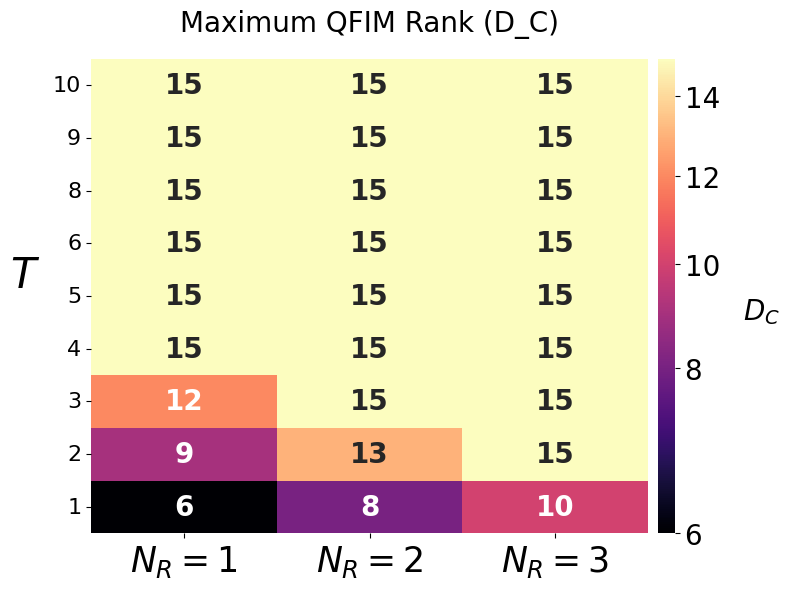

Descr: The mean of the spread-of-log values computed using the variance method. This metric quantifies the average dispersion of the logarithms of the normalized eigenvalues.


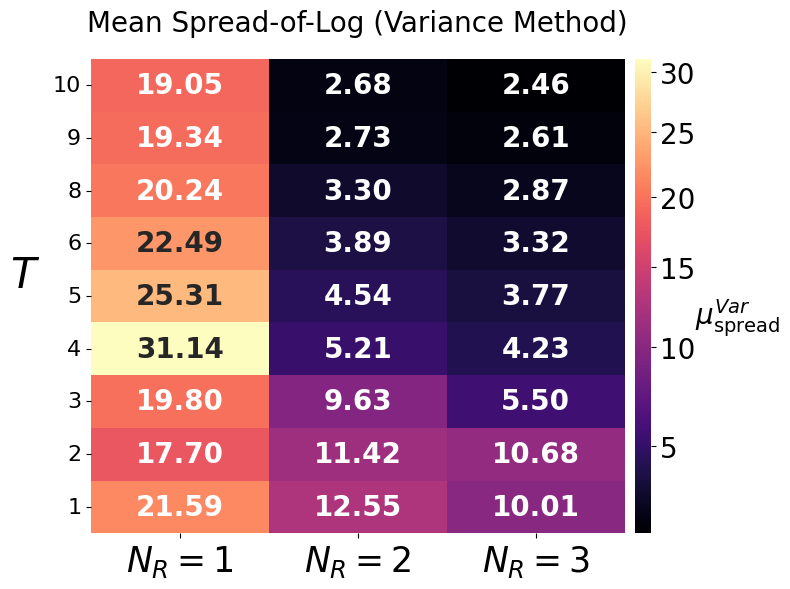

Descr: 


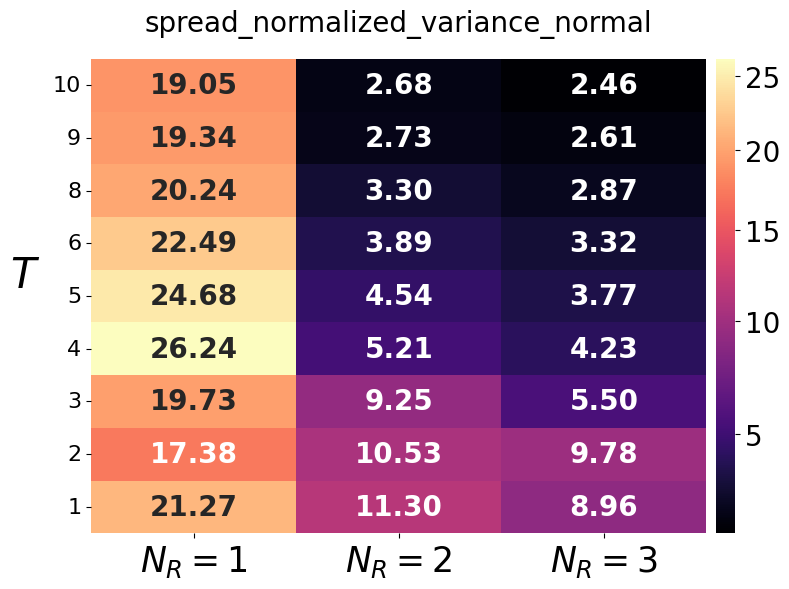

Descr: 


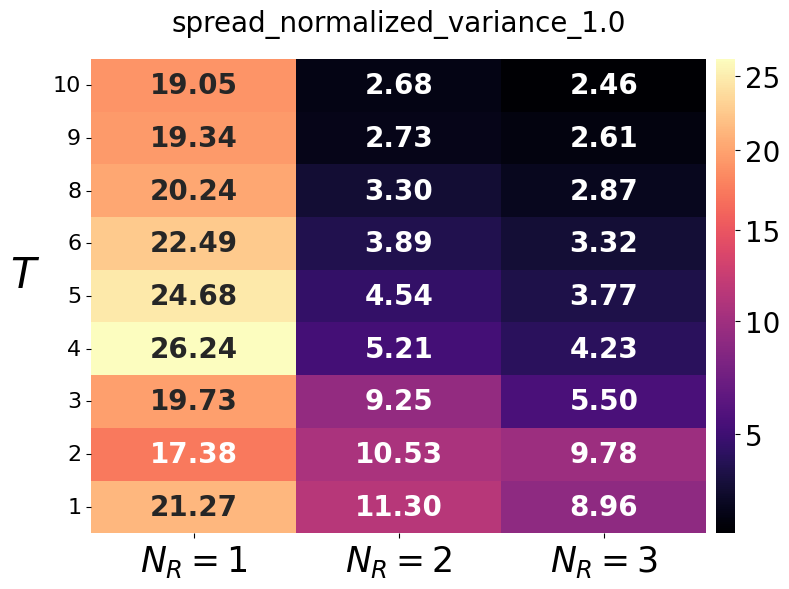

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
chosen_n_ctrl=2
N_ctrl = chosen_n_ctrl
def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3]

    # 2) Decide how to pick Trotter steps based on N_ctrl
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
    elif N_ctrl == 3:
        trots = np.arange(1, 60, 1)  # or your preferred range
    else:
        # trots = [1, 2, 3, 4, 5, 6, 8, 9, 10,11, 12,13, 14, 16, 18, 20]
        trots = [1, 2, 3, 4, 5, 6, 8, 9, 10]

    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary

        metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        metric_cbar  = metrics_info.get(metric_key, {}).get('label', '')
        metric_descr  = metrics_info.get(metric_key, {}).get('description', '')
        print(f"Descr: {metric_descr}")

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "D_C":
            annotation_matrix = heatmap_pivot.map(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.map(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(8, 6))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=0.7, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=16)
        ax.tick_params(axis='x', labelsize=16)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=25, rotation=0)

        plt.tight_layout()
        plt.show()

metric_keys = ['D_C',"spectrum_shape_avg_ipr_deffs_norm",'spectrum_shape_avg_abbas_deffs_norm','avg_abbas_deffs_raw', 'spread_mean_per_sample_variance_normal', 'spread_mean_per_sample_mad_normal']
# metric_keys = ['absolute_scale_avg_var_nonzero','avg_per_active_mode_avg_var_norm_rank','spread_mean_per_sample_variance_normal']
metric_keys = ['D_C',"spread_mean_per_sample_variance_normal","spread_normalized_variance_normal","spread_normalized_variance_1.0"]
# metric_keys = ['D_C', "spread_mean_per_sample_mad_normal","absolute_scale_avg_var_nonzero","absolute_scale_global_var_nonzero","normalized_avg_var_nonzero","normalized_global_var_nonzero"]
# 'spectrum_shape_ipr_deffs_norm_per_draw',
#        'spectrum_shape_avg_ipr_deffs_norm',
#        'spectrum_shape_abbas_deffs_norm_per_draw',
#        'spectrum_shape_avg_abbas_deffs_norm',
plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])

Descr: The mean raw Abbas dimension across draws, summarizing the overall effective dimension in absolute scale.


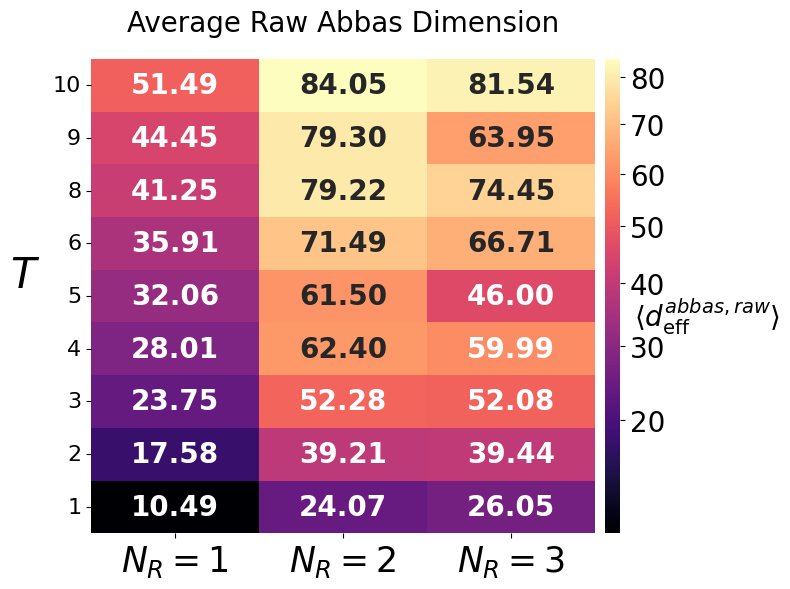

Descr: 


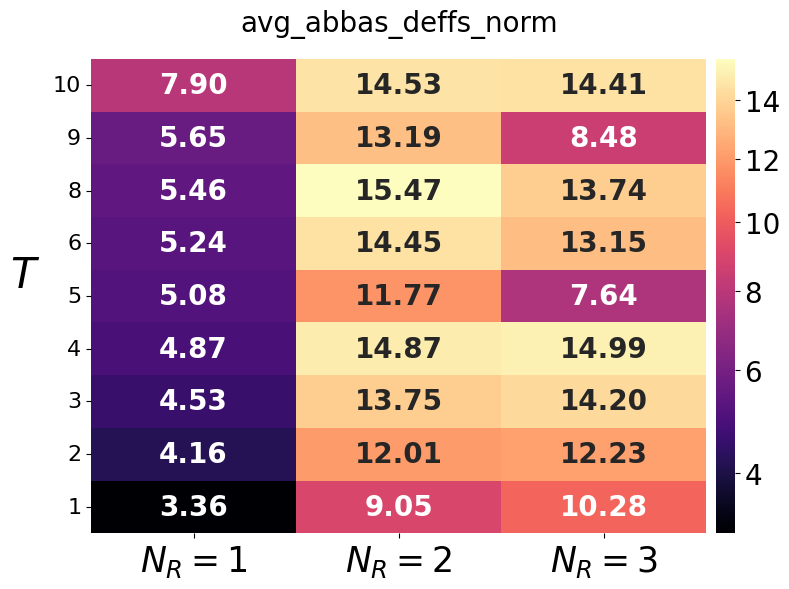

Descr: 


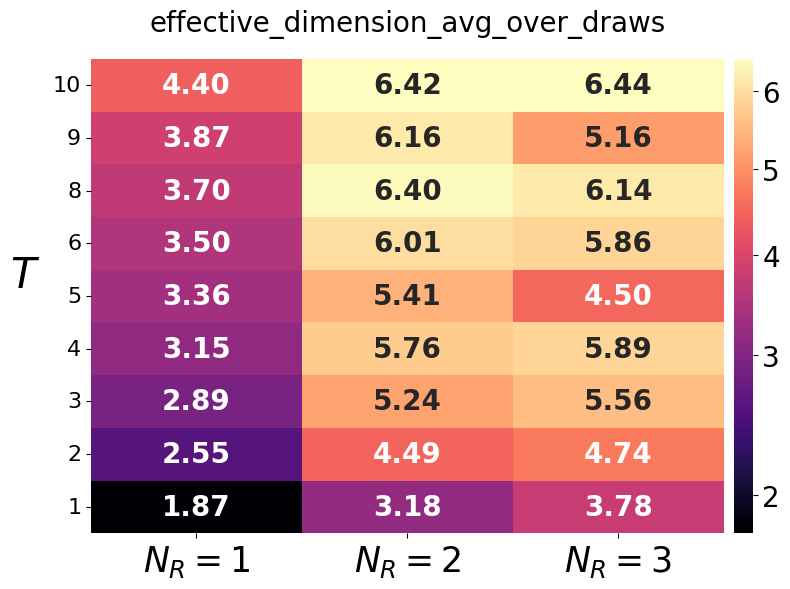

Descr: 


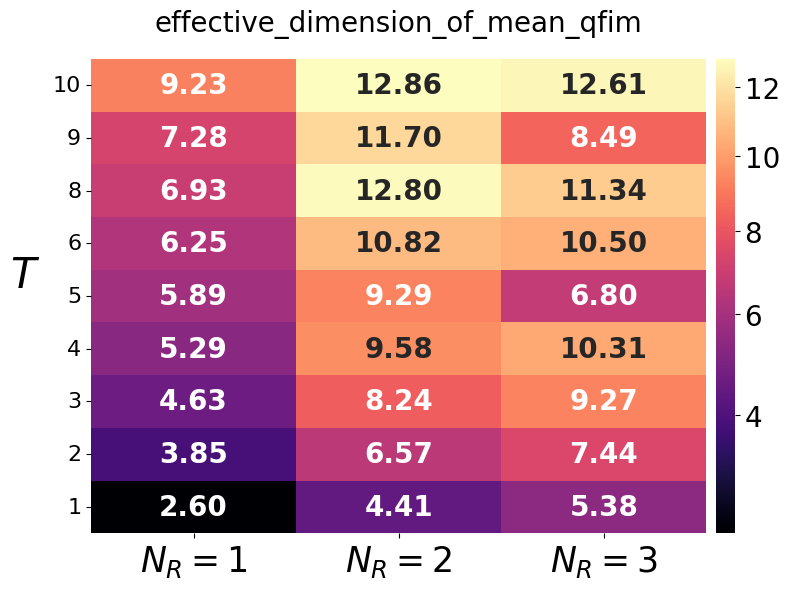

In [83]:
metric_keys = [ 'avg_abbas_deffs_raw','avg_abbas_deffs_norm', 'effective_dimension_avg_over_draws',
       'effective_dimension_of_mean_qfim',]
# 'spectrum_shape_ipr_deffs_norm_per_draw',
#        'spectrum_shape_avg_ipr_deffs_norm',
#        'spectrum_shape_abbas_deffs_norm_per_draw',
#        'spectrum_shape_avg_abbas_deffs_norm',
plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])

[INFO] For N_ctrl=2, N_reserv=2, Detected critical T_C = 3 where M = 18 (15 w/ no time params)
[INFO] For N_ctrl=2, N_reserv=2, peak T_C is 2

[INFO] For N_ctrl=2, N_reserv=2, peak T_C is 2



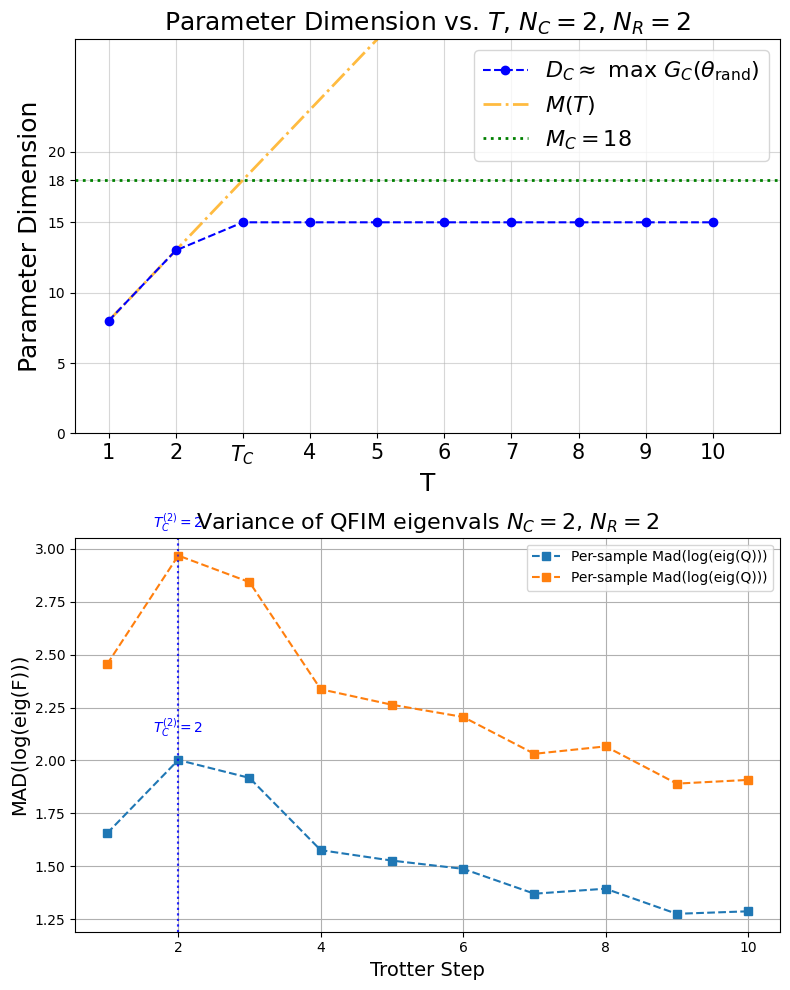

In [81]:
def plot_spread_analysis(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                         spread_type="variance", combination="pooled",
                         show_yerr=False, title=None, xlabel="Trotter Step",
                         ylabel=None, num_ticks=6, scale='normal'):
    """
    Plots the spread analysis based on the given spread type and combination technique,
    *with* an annotated T_C vertical line (T_C^{(N_R)}).
    
    Parameters:
    -----------
    - df: DataFrame containing spread data.
    - chosen_n_ctrl: Selected N_ctrl value.
    - chosen_n_reserv: Selected N_reserv value.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - spread_type: 'variance' or 'mad'.
    - combination: 'pooled' or 'sampled'.
    - show_yerr: Whether to plot error bars (for sample-based only).
    - title: Title of the plot.
    - xlabel, ylabel: Axis labels.
    - num_ticks: number of x-ticks to generate.
    - scale: 'normal', etc., to match your naming in df columns.
    """

    # Ensure valid inputs
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")
    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be 'pooled' or 'sampled'")

    # Filter data for the chosen N_ctrl, N_reserv
    df_plot = df.query("N_ctrl==@chosen_n_ctrl & N_reserv==@chosen_n_reserv").copy()
    df_plot.sort_values("Trotter_Step", inplace=True)

    # Extract x values
    x_vals = df_plot["Trotter_Step"].values

    # Column names for y-values
    y_mean_key = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_std_key  = f"spread_std_per_sample_{spread_type}_{scale}"
    # y_pool_key = f"spread_val_pooled_{spread_type}_{scale}"

    y_mean, y_std = (
        df_plot[y_mean_key].values,
        df_plot[y_std_key].values,
        # df_plot[y_pool_key].values
    )

    # Decide which array to use for peak detection & plotting
    if combination == "sampled":
        data_for_peak = y_mean
        data_label = f"Per-sample {spread_type.capitalize()}(log(eig(Q)))"
    else:  # "pooled"
        data_for_peak = y_pool
        data_label = f"Pooled {spread_type.capitalize()}(log(eig(Q)))"

    # Identify peak (T_C)
    peak_idx = int(np.argmax(data_for_peak))
    peak_T   = x_vals[peak_idx]
    peak_val = data_for_peak[peak_idx]
    print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, "
          f"peak T_C is {peak_T}\n")

    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Actually plot
    if combination == "sampled":
        if show_yerr:
            ax.errorbar(
                x_vals, y_mean, yerr=y_std, fmt="o--",
                capsize=4, label=f"{data_label} ± std"
            )
        else:
            ax.plot(
                x_vals, y_mean, "s--", label=data_label
            )
    else:  # combination == "pooled"
        ax.plot(x_vals, y_pool, "s--", label=data_label)

    # Construct x-ticks, ensuring T=1 and T_C are included
    # x_ticks = np.linspace(min(x_vals), max(x_vals), num=num_ticks, dtype=int)
    # x_ticks = np.unique(np.append(x_ticks, [1, peak_T]))  # ensure T=1 & T_C

    # # Label T_C explicitly on x-axis
    # xtick_labels = [f"$T_C$" if tick == peak_T else str(tick) for tick in x_ticks]
    # ax.set_xticks(x_ticks)
    # ax.set_xticklabels(xtick_labels, fontsize=15)

    # 2) Annotate T_C with a vertical line plus a text label T_C^{(N_reserv)}
    ax.axvline(x=peak_T, color='b', linestyle=':', alpha=0.6)
    ax.text(
        peak_T, peak_val + 0.1,
        fr"$T_C^{{({chosen_n_reserv})}}={peak_T}$",
        fontsize=10, color='b',
        ha='center', va='bottom'
    )

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)
    if not title:
        title=f'Variance of QFIM eigenvals $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    ax.set_title(title or f"{spread_type.capitalize()}-based Spread Analysis", fontsize=16)
    ax.grid(True)
    ax.legend()

    return ax

def get_num_params(N_r, N_c, T, model_type = 'digital'):
        if model_type == 'analog':
            return N_r * N_c * T + 3 + T
        elif model_type == 'digital':
            return N_r * N_c * T + 3
        else:
             raise TypeError(f'No model type: {model_type}')
def plot_max_rank_vs_params(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                            xlabel='T', ylabel='Parameter Dimension', title=None,
                            color='b', param_color='orange', critical_color='green',
                            legend_loc='upper right',num_ticks=10):
    """
    Plots max rank vs. parameters for given control and reservoir values.

    Parameters:
    - df: DataFrame containing 'Trotter_Step', 'N_ctrl', 'N_reserv', 'QFIM_ranks'.
    - chosen_n_ctrl: Selected control value for filtering.
    - chosen_n_reserv: Selected reservoir value for filtering.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - xlabel, ylabel: Axis labels.
    - title: Title of the plot.
    - color: Color for max rank plot line.
    - param_color: Color for parameter dimension line.
    - critical_color: Color for the critical threshold line.
    - legend_loc: Legend location.
    """
    
    # Filter for chosen values
    subset = df[(df['N_ctrl'] == chosen_n_ctrl) & (df['N_reserv'] == chosen_n_reserv)]
    
    trotter_steps, max_ranks = [], []
    for T_step, grp in subset.groupby('Trotter_Step'):
        all_ranks = [rank for row in grp['QFIM_ranks'] for rank in row]
        max_rank = np.max(all_ranks) if all_ranks else 0
        trotter_steps.append(T_step)
        max_ranks.append(max_rank)

    # Sort data
    trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

    # Compute parameter dimension M(T)
    # param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t, model_type="digital") for t in trotter_steps]
    param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t, model_type="analog") for t in trotter_steps]

    # Detect critical T_C
    idx_C = int(np.argmax(max_ranks))
    T_C, M_C, D_C = trotter_steps[idx_C], param_list[idx_C], max_ranks[idx_C]
    print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, Detected critical T_C = {T_C} where M = {M_C} ({M_C-T_C} w/ no time params)")
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot max rank vs. Trotter step
    ax.plot(trotter_steps, max_ranks, marker='o', linestyle='--', color=color,
            label=r'$D_C \approx$ max $G_C(\theta_{\text{rand}})$', zorder=10)
    
    # Plot M(T)
    ax.plot(trotter_steps, param_list, color=param_color, linestyle='-.',
            alpha=0.75, linewidth=2, label='$M(T)$')
    
    # Horizontal line at M_C
    ax.axhline(y=M_C, color=critical_color, linestyle=':', linewidth=2, label=f'$M_C={M_C}$')

    # X-axis ticks: evenly spaced, always including T=1 and T_C
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1, T_C]))  # Ensure T=1 and T_C are always included

    # Labeling T_C explicitly
    xtick_labels = [f"$T_C$" if tick == T_C else str(tick) for tick in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xtick_labels, fontsize=15)
    


    # Y-axis: Ensure labels are integers
    yticks = list(np.arange(0, max(max_ranks) + 10, step=5))
    if M_C not in yticks:
        yticks.append(M_C)
    
    ax.set_yticks(yticks)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.legend(fontsize=16, loc=legend_loc)
    ax.grid(True, alpha=0.5)
    ax.set_ylim(top=M_C + 10)
    ax.set_xlim(left=0.5, right=max(trotter_steps)+1)
    if not title:
        title=f'Parameter Dimension vs. $T$, $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    if title:
        ax.set_title(title, fontsize=18)

    return ax
chosen_n_reserv = 2
chosen_n_ctrl = 2
selected_T_plot = np.arange(1,11,1)
df_filtered = df_with_stats[df_with_stats['Trotter_Step'].isin(selected_T_plot)]
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
plot_max_rank_vs_params(df_filtered, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, ax=axes[0])
plot_spread_analysis(df_filtered, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="mad", combination="sampled", scale='1.0',ax=axes[1])
plot_spread_analysis(df_filtered, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="mad", combination="sampled", scale='normal',ax=axes[1])
# plot_spread_analysis(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="variance", combination="sampled",scale=1.0, ax=axes[1])

plt.tight_layout()
plt.show()

[INFO] For N_ctrl=2, N_reserv=1, Detected critical T_C = 4 where M = 15 (11 w/ no time params)
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 4

[INFO] For N_ctrl=2, N_reserv=2, Detected critical T_C = 3 where M = 18 (15 w/ no time params)
[INFO] For N_ctrl=2, N_reserv=2, peak T_C is 2

[INFO] For N_ctrl=2, N_reserv=3, Detected critical T_C = 2 where M = 17 (15 w/ no time params)
[INFO] For N_ctrl=2, N_reserv=3, peak T_C is 2



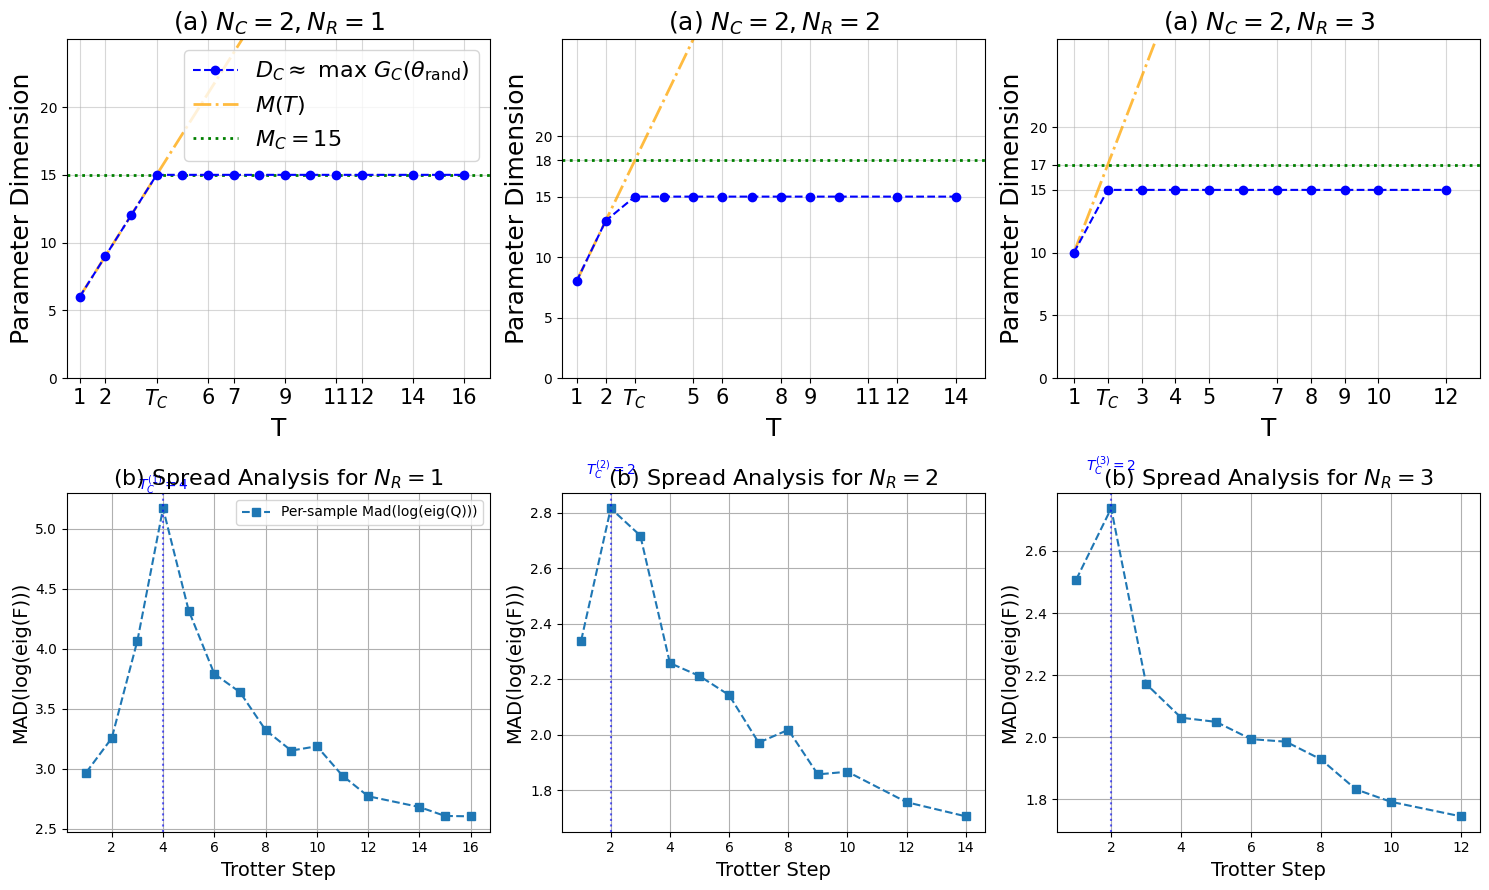

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_many_reserv(df, N_ctrl=2, reserv_list=[1, 2, 3], spread_type="mad"):
    """
    Creates a 2xN grid of subplots, with the top row showing plot_max_rank_vs_params
    and the bottom row showing plot_spread_analysis, each column for a different N_R.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing your QFIM info (with 'N_ctrl','N_reserv','Trotter_Step', etc.).
    N_ctrl : int
        The control qubit count to fix for all columns.
    reserv_list : list of int
        The distinct N_reserv values you want to show (e.g. [1, 2, 3]).
    spread_type : str
        'variance' or 'mad', as accepted by your plot_spread_analysis function.

    Returns:
    --------
    fig, axes : The figure and axes objects for further customization.
    """

    # Number of columns is the length of reserv_list
    ncols = len(reserv_list)
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(5*ncols, 9), sharex=False, sharey=False)

    # If there is only 1 column, make sure we index axes as 2D
    if ncols == 1:
        # shape would be (2, ) if there's only one column
        axes = np.array([axes]).T  # transform to shape (2,1)

    for col_idx, nr_val in enumerate(reserv_list):
        # ------------------
        # Top row: max-rank vs. T
        # ------------------
        ax_top = axes[0, col_idx]
        plot_max_rank_vs_params(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val, ax=ax_top,
            xlabel="T", ylabel="Parameter Dimension",
            title=f"(a) $N_C={N_ctrl}, N_R={nr_val}$"
        )

        # Hide repeated legends if you only want them once:
        if col_idx > 0:
            ax_top.legend_.remove()

        # ------------------
        # Bottom row: spread analysis
        # ------------------
        ax_bot = axes[1, col_idx]
        plot_spread_analysis(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val,
            ax=ax_bot, spread_type=spread_type, combination="sampled",
            xlabel="Trotter Step", ylabel=f"{spread_type.upper()}(log(eig(F)))",
            title=f"(b) Spread Analysis for $N_R={nr_val}$"
        )

        if col_idx > 0:
            # Similarly remove legends if you want minimal duplication
            # Or keep them if you prefer each subplot to have its own
            ax_bot.legend_.remove()

    plt.tight_layout()
    return fig, axes

# Example usage:
fig, axes = plot_many_reserv(df_with_stats, N_ctrl=2, reserv_list=[1,2,3], spread_type="mad")
# plt.show()

Descr: The mean variance computed over all eigenvalues across draws, reflecting the typical spread of the eigenvalue distributions on an absolute scale.


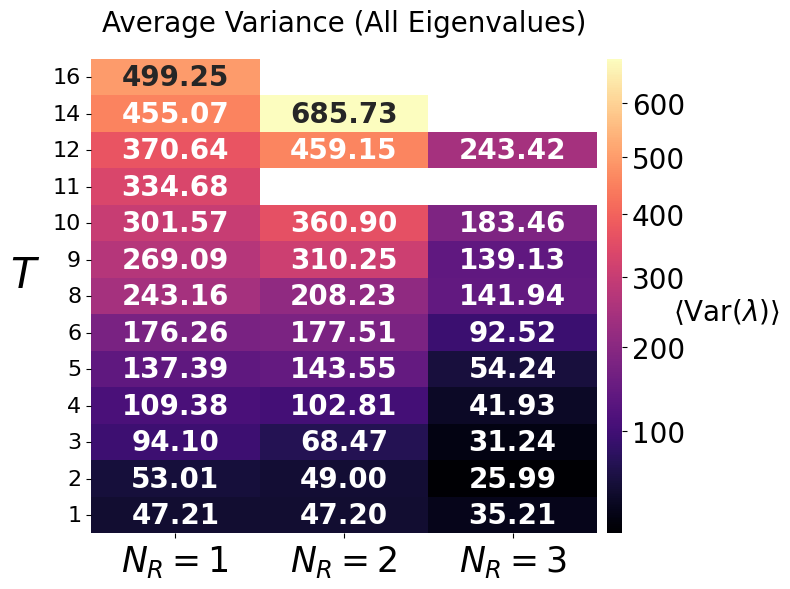

Descr: The mean variance computed over only the nonzero eigenvalues across draws, measuring the typical dispersion among the significant eigenvalues.


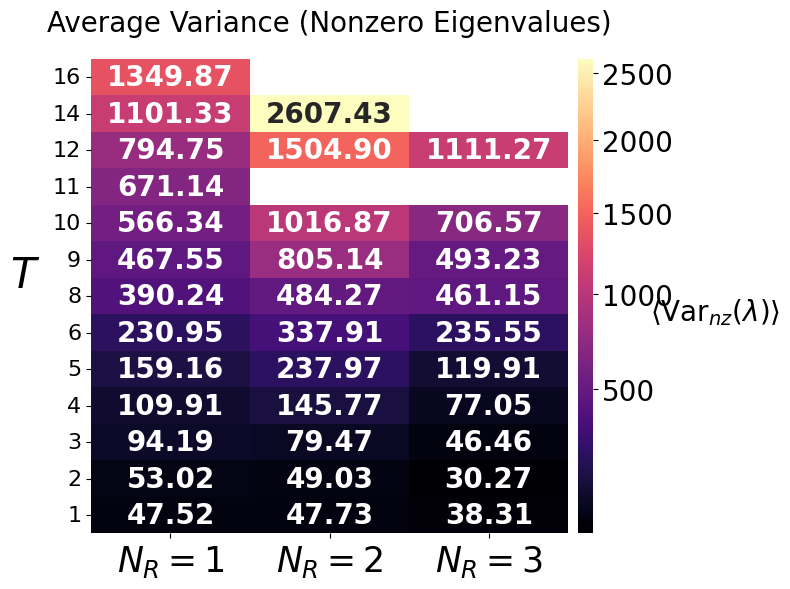

Descr: The average of the variance-per-rank values over all draws, reflecting the typical dispersion per active mode.


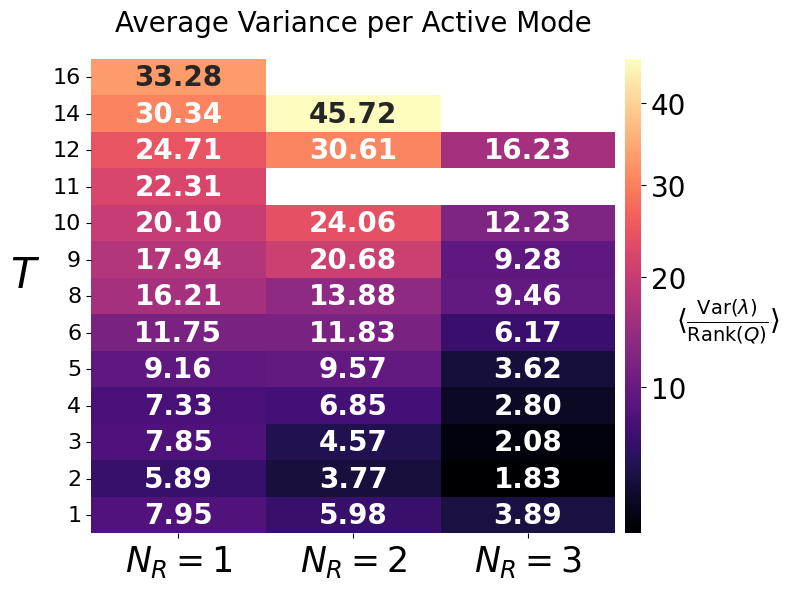

In [11]:
metric_keys = ['absolute_scale_avg_var_all', 'absolute_scale_avg_var_nonzero','avg_per_active_mode_avg_var_norm_rank']
plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])

In [23]:
config_df = df_with_stats[(df_with_stats['N_ctrl'] == 2) & (df_with_stats['N_reserv'] == 1)]
print("Number of rows for configuration (N_ctrl=2, N_reserv=1):", config_df.shape[0])
# print(np.array(config_df['all_qfim_eigvals'][1]).shape)
# print(config_df['qfim_eigs_2d'][1].shape)
# Option 1: Check uniqueness within each row.
print("\nChecking uniqueness within each row:")
for idx, row in config_df.iterrows():
    eig_sets = row["all_qfim_eigvals"]
    # Convert each eigenvalue set to a hashable tuple.
    # (Flatten the array, round for stability, and convert to a tuple.)
    eig_tuples = [tuple(np.round(np.array(eig).flatten(), decimals=5)) for eig in eig_sets]
    if len(eig_tuples) == len(set(eig_tuples)):
         print(f"T={row['Trotter_Step']}: All {len(eig_tuples)} eigenvalue sets are unique.")
    else:
         print(f"T={row['Trotter_Step']}: Duplicate eigenvalue sets found! {np.array(eig_sets).shape}")

Number of rows for configuration (N_ctrl=2, N_reserv=1): 15

Checking uniqueness within each row:
T=1: All 100 eigenvalue sets are unique.
T=10: All 200 eigenvalue sets are unique.
T=11: All 200 eigenvalue sets are unique.
T=12: All 200 eigenvalue sets are unique.
T=14: All 100 eigenvalue sets are unique.
T=15: All 100 eigenvalue sets are unique.
T=16: All 100 eigenvalue sets are unique.
T=2: All 100 eigenvalue sets are unique.
T=3: All 100 eigenvalue sets are unique.
T=4: All 100 eigenvalue sets are unique.
T=5: All 100 eigenvalue sets are unique.
T=6: All 100 eigenvalue sets are unique.
T=7: All 100 eigenvalue sets are unique.
T=8: All 100 eigenvalue sets are unique.
T=9: All 100 eigenvalue sets are unique.


In [15]:
config_df = df_with_stats[(df_with_stats['N_ctrl'] == 2) & (df_with_stats['N_reserv'] == 2)]
print("Number of rows for configuration (N_ctrl=2, N_reserv=1):", config_df.shape[0])
# print(np.array(config_df['all_qfim_eigvals'][1]).shape)
# print(config_df['qfim_eigs_2d'][1].shape)
# Option 1: Check uniqueness within each row.
print("\nChecking uniqueness within each row:")
for idx, row in config_df.iterrows():
    eig_sets = row["all_qfim_eigvals"]
    # Convert each eigenvalue set to a hashable tuple.
    # (Flatten the array, round for stability, and convert to a tuple.)
    eig_tuples = [tuple(np.round(np.array(eig).flatten(), decimals=5)) for eig in eig_sets]
    if len(eig_tuples) == len(set(eig_tuples)):
         print(f"T={row['Trotter_Step']}: All {len(eig_tuples)} eigenvalue sets are unique.")
    else:
         print(f"T={row['Trotter_Step']}: Duplicate eigenvalue sets found! {np.array(eig_sets).shape}")

Number of rows for configuration (N_ctrl=2, N_reserv=1): 13

Checking uniqueness within each row:
T=1: All 1000 eigenvalue sets are unique.
T=12: All 1000 eigenvalue sets are unique.
T=16: All 1000 eigenvalue sets are unique.
T=4: All 1000 eigenvalue sets are unique.
T=8: All 1000 eigenvalue sets are unique.
T=10: All 500 eigenvalue sets are unique.
T=11: All 300 eigenvalue sets are unique.
T=2: All 500 eigenvalue sets are unique.
T=3: All 500 eigenvalue sets are unique.
T=5: All 500 eigenvalue sets are unique.
T=6: All 500 eigenvalue sets are unique.
T=7: All 500 eigenvalue sets are unique.
T=9: All 500 eigenvalue sets are unique.


In [10]:
threshold = 1e-8
def compute_ipr_dimension(eigvals, threshold):
    """
    Compute the IPR-based dimension for a single array of eigenvalues:
       d_eff = (sum(eigvals)^2) / sum(eigvals^2)
    Only eigenvalues above 'threshold' are retained.
    """
    # Filter out small or zero eigenvalues
    filtered_vals = [val for val in eigvals if val > threshold]
    
    if len(filtered_vals) == 0:
        # If no eigenvalues are above threshold, dimension is effectively 0
        return 0.0
    
    sum_eigs = np.sum(filtered_vals)
    sum_eigs_sq = np.sum(np.square(filtered_vals))
    
    # Avoid division by zero if sum_eigs_sq happens to be extremely small
    if sum_eigs_sq == 0:
        return 0.0
    
    return (sum_eigs ** 2) / sum_eigs_sq

df_with_stats['test_ipr_dims'] = df_with_stats['all_qfim_eigvals'].apply(
    lambda list_of_eigval_arrays: [
        compute_ipr_dimension(eigvals, threshold=threshold)
        for eigvals in list_of_eigval_arrays
    ]
)

# Average IPR dimension across all tests in each row
df_with_stats['avg_test_ipr_dim'] = df_with_stats['test_ipr_dims'].apply(np.mean)


Descr: The maximum rank observed across all draws. This serves as a simple estimate of the model's maximum effective capacity.


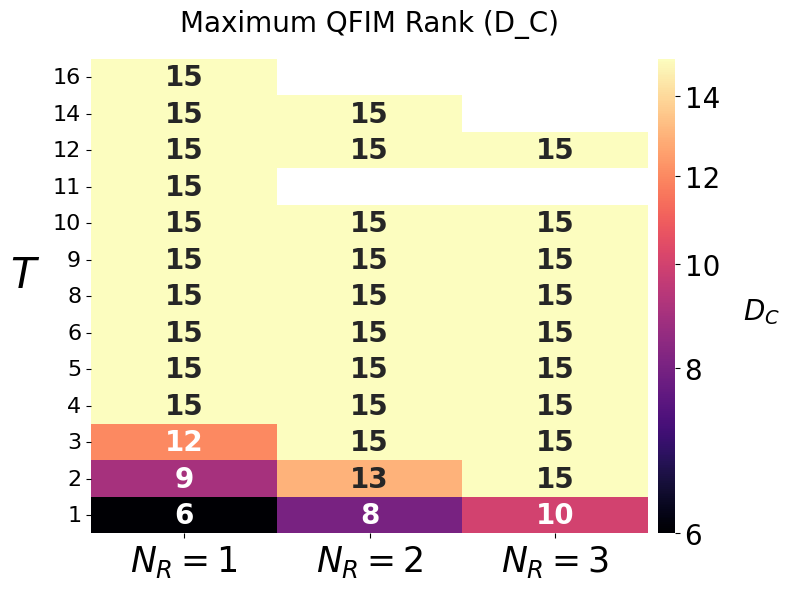

Descr: The mean of the spread-of-log values computed using the median absolute deviation (MAD) method. It provides an alternative measure of the dispersion of the normalized eigenvalue spectrum.


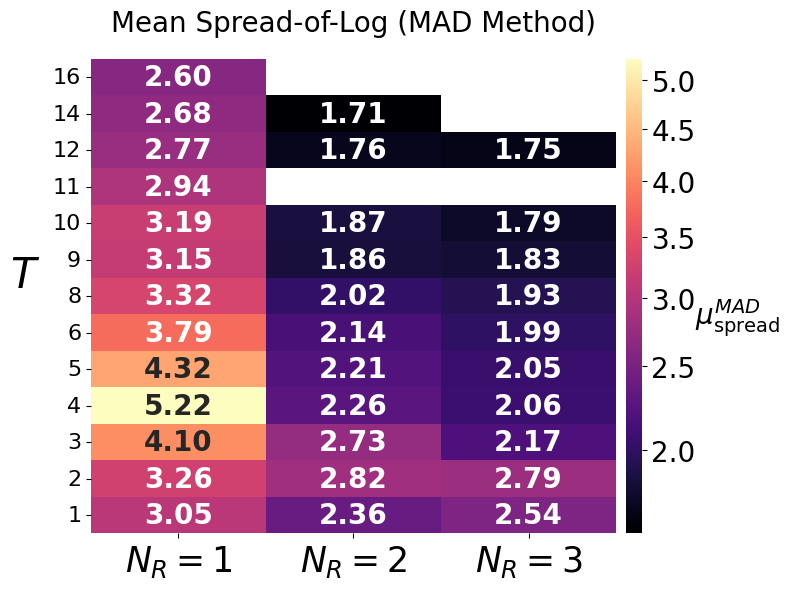

Descr: 


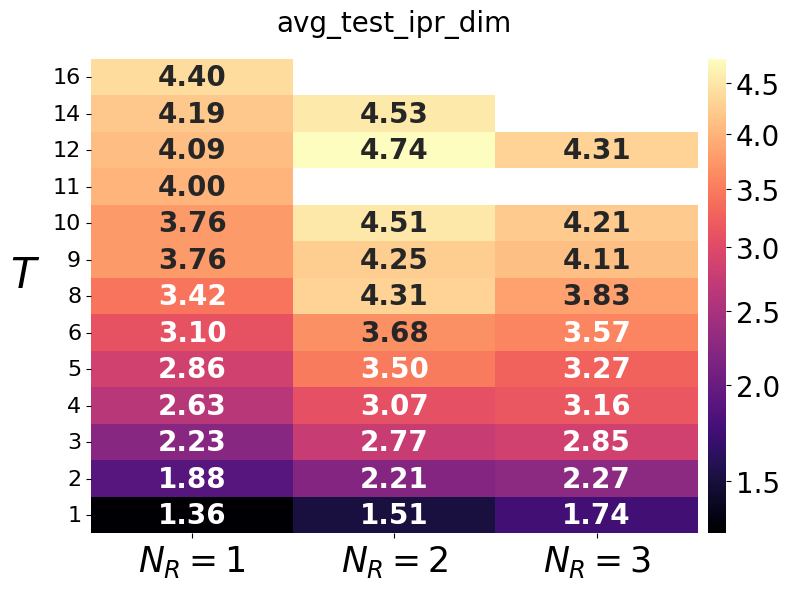

Descr: 


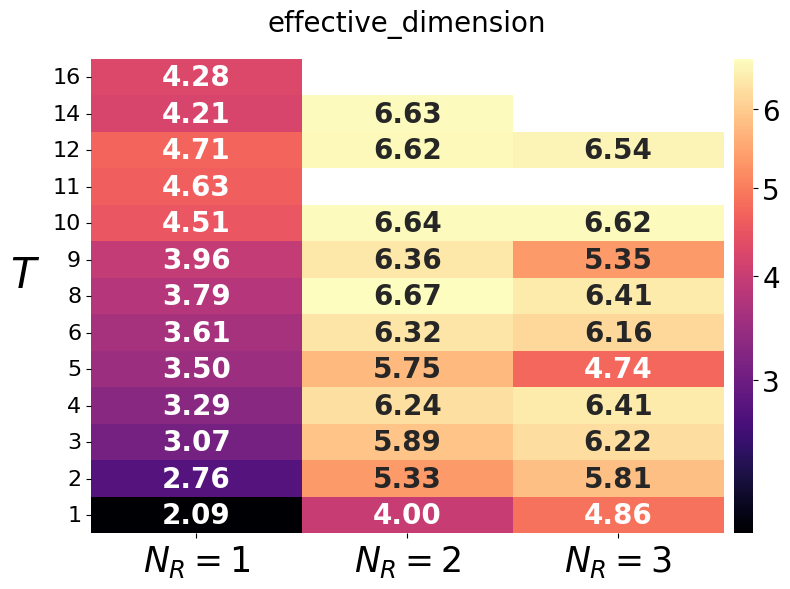

In [41]:
df_with_stats.columns

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys', 'key_pair_tuple',
       'qfim_eigs_2d', 'QFIM_ranks', 'var_all_eigenvals_per_draw',
       'var_nonzero_eigenvals_per_draw', 'trace_eigenvals_per_draw', 'D_C',
       'absolute_scale_avg_var_all', 'absolute_scale_avg_var_nonzero',
       'absolute_scale_avg_trace', 'absolute_scale_var_of_var_all',
       'absolute_scale_var_of_var_nonzero',
       'avg_per_active_mode_var_norm_rank_per_draw',
       'avg_per_active_mode_trace_norm_rank_per_draw',
       'avg_per_active_mode_avg_var_norm_rank',
       'avg_per_active_mode_avg_trace_norm_rank', 'ipr_deffs_raw_per_draw',
       'spectrum_shape_avg_ipr_deffs_raw', 'ipr_deffs_norm_per_draw',
       'spectrum_shape_avg_ipr_deffs_norm', 'abbas_deffs_raw_per_draw',
       'avg_abbas_deffs_raw', 'abbas_deffs_norm_per_draw',
       'avg_abbas_deffs_norm', 'effective_dimension',
       'spread_mean_per_sample_variance_no

Descr: The mean variance computed over all eigenvalues across draws, reflecting the typical spread of the eigenvalue distributions on an absolute scale.


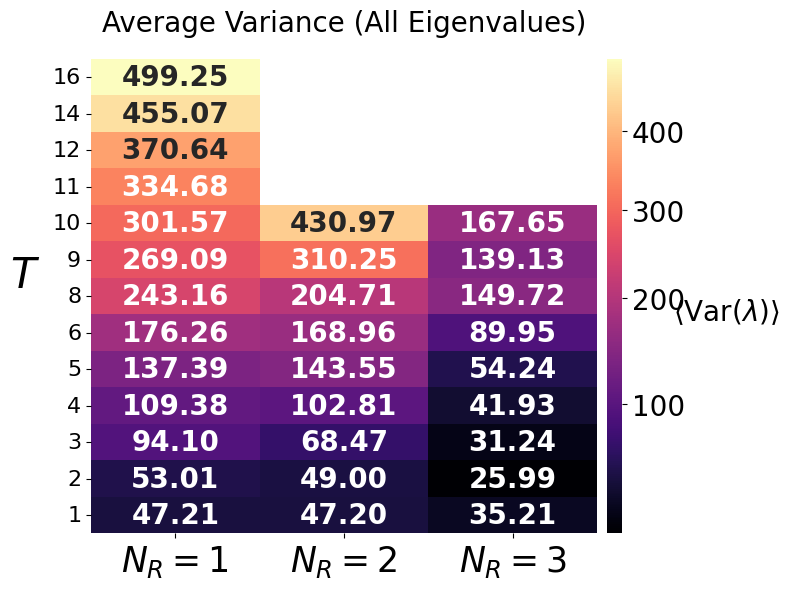

Descr: The mean variance computed over only the nonzero eigenvalues across draws, measuring the typical dispersion among the significant eigenvalues.


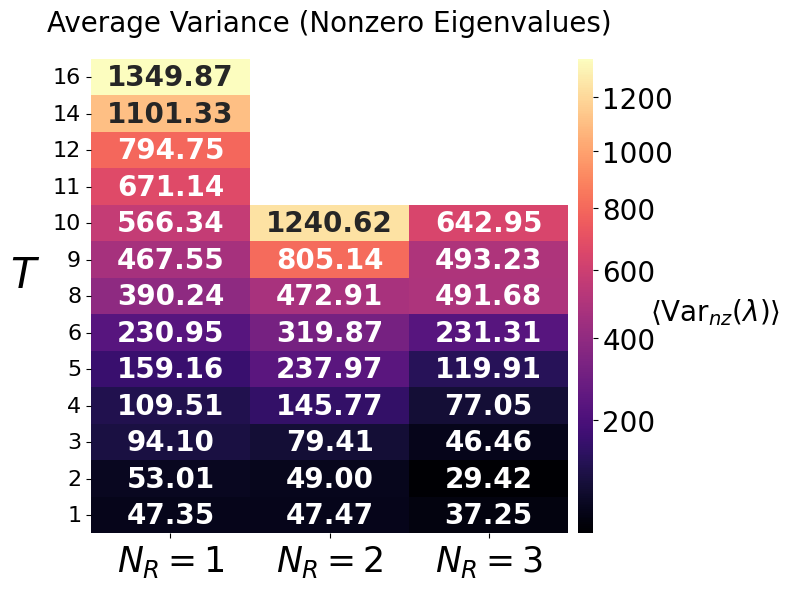

Descr: The average of the variance-per-rank values over all draws, reflecting the typical dispersion per active mode.


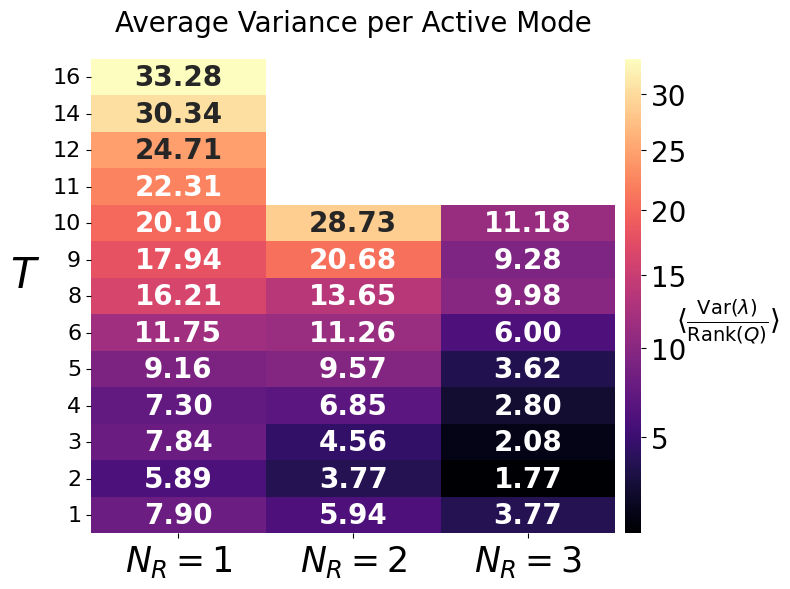

In [45]:
metric_keys = ['absolute_scale_avg_var_all', 'absolute_scale_avg_var_nonzero','avg_per_active_mode_avg_var_norm_rank']
plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])

In [8]:
from qfim_store import spread_per_sample_vectorized,spread_pooling_vectorized,to_2d, compute_ipr_dimension


def compute_all_stats(
    eigval_list,
    threshold=1e-12,
    spread_methods=("variance", "mad"),  # e.g. ["variance", "mad"]
    ddof=1,
    scale="normal",
    # Additional args for the approximate effective dimension
    do_effective_dim=True,
    n = 1,
     # NEW ARGS for Qiskit-like step:
    qfim_mats_list=None,
    dataset_sizes=None,
 
):
    """
    Compute QFIM statistics for a list of draws (eigval_list) corresponding to one experimental run.
    
    Here, each element of eigval_list represents the raw QFIM eigenvalues computed
    from a single draw (i.e. one sample of randomly generated trainable parameters) for a 
    given configuration (specified by a unique combination of N_ctrl, reservoir qubits (N_R),
    and Trotter step (T)). 

    Parameters
    ----------
    eigval_list : List[List[float]] or List[np.ndarray]
        Each element of eigval_list represents the QFIM eigenvalues computed for 
        a single random draw (trainable parameters) in your experiment.
    threshold : float
        Threshold for zeroing out near-zero eigenvalues.
    spread_methods : tuple of str
        Methods for spread-of-log computations. Possible values: "variance", "mad", "median".
    ddof : int
        Delta degrees of freedom for variance-based computations.
    scale : str
        Scale for median_abs_deviation in "mad" case.
    do_effective_dim : bool
        Whether to compute IPR-based and Abbas-based effective dimension metrics.
    qfim_mats_list : List[np.ndarray], optional
        If provided, each element is the *full NxN QFIM matrix* for that draw. 
        Must be the same length as eigval_list. 
        We'll average them and do the determinant-based dimension from Qiskit's approach.
    dataset_sizes : int or list of ints, optional
        The 'n' or array of 'n' values for computing the final dimension. 
        By default, Qiskit's code calls this 'dataset_size'. 
        If None, we skip the global ED calculation.

        Notes on the Three Categories of Metrics:
      1) ABSOLUTE SCALE: e.g. raw trace and raw variance (sums of eigenvalues, etc.).
      2) SHAPE OF THE SPECTRUM: e.g. normalized IPR, normalized Abbas dimension, 
         which ignore total magnitude by normalizing eigenvalues to sum=1.
      3) AVERAGE PER NONZERO MODE: e.g. trace/rank, variance/rank.

    For each draw, the following metrics are computed:
      - rank: Number of nonzero eigenvalues after applying the threshold.
      - var_qfim_eigvals: Variance computed on all eigenvalues.
      - var_qfim_eigvals_nonzero: Variance computed on nonzero eigenvalues only.
      - trace: Sum of eigenvalues (i.e. the trace of the QFIM).
      - var_norm_len: Variance normalized by the total number of eigenvalues.
      - trace_norm_len: Trace normalized by the total number of eigenvalues.
      - var_norm_rank: Variance normalized by the rank (number of nonzero eigenvalues).
      - trace_norm_rank: Trace normalized by the rank.
      - Spread metrics: For each method in spread_methods (e.g. "variance", "mad"), compute the spread of the log of the eigenvalues.
      - effective_dimension: TODO

      
     Returns
    -------
    metrics : dict
        Dictionary containing per-draw lists and aggregated statistics. 
        The keys are split into categories:

        [1] "absolute_scale_*" ...
        [2] "spectrum_shape_*" ...
        [3] "avg_per_active_mode_*" ...
        
        ... plus spread-of-log metrics for each method in spread_methods.
    
    Additional Notes:
    -----------------
    This function assumes that eigval_list is a list of 1D arrays (or lists),
    where each array corresponds to the QFIM eigenvalues computed for a single
    random draw of trainable parameters. The computed metrics are intended to capture
    both per-draw variability and the overall (pooled) behavior of the QFIM eigenvalue distribution,
    which are later used to correlate with measures of learnability and generalization.
    """

    import numpy as np

    # -------------------------------------------------------------------------
    # 1) Per-draw computations
    # -------------------------------------------------------------------------
    ranks_per_draw = []
    var_all_per_draw = []     # raw variance (absolute scale)
    var_nonzero_per_draw = [] # raw variance of nonzero eigenvals only
    trace_per_draw = []       # raw trace (absolute scale)

    var_norm_rank_per_draw = []   # average per nonzero mode
    trace_norm_rank_per_draw = [] # average per nonzero mode

    # Effective dimension (IPR & Abbas) - raw vs. normalized
    ipr_deffs_raw    = []
    ipr_deffs_norm   = []
    abbas_deffs_raw  = []
    abbas_deffs_norm = []
    abbas_deffs_norm_by_gc = []

    # For Abbas measure (optional local dimension approach)
    # =============== NEW #2: Abbas local dimension ===============
    # d_{n, gamma}(theta) ~ -log(V_theta) + sum_i log(1 + alpha * lambda_i)
    # We'll just set V_theta=1 => -log(1)=0, so that term vanishes.
    # Then we do sum(log(1 + alpha * lambda_i)).
    # If alpha*lambda_i < -1, that log is undefined; in practice, alpha*lambda_i >= 0 if alpha>0, lambda_i >= 0

    n_draws = len(eigval_list)   # interpret as "number of random draws"
    # n_draws = n
    # For Abbas measure (a local version)
    gamma = 1.0
    if n_draws > 1:
        alpha = (gamma * n_draws) / (2.0 * np.log(n_draws))
    else:
        alpha = 0.0
    V_theta = 1.0  # placeholder

    for eigs in eigval_list:
        arr = np.array(eigs, dtype=float)
       
        arr = np.where(arr < threshold, 0.0, arr)   # threshold small values
        # rank = #nonzero eigenvalues
        rank = np.count_nonzero(arr)
        ranks_per_draw.append(rank)

        # raw variance + trace = "absolute scale"
        var_all = np.var(arr)
        trace_val = arr.sum()

        var_all_per_draw.append(var_all)
        trace_per_draw.append(trace_val)

        # variance over nonzero eigenvals (still absolute scale, ignoring zeros)
        nonz = arr[arr > 0]
        var_non = np.var(nonz) if nonz.size > 1 else 0.0
        var_nonzero_per_draw.append(var_non)

        
        var_norm_rank_per_draw.append(var_all / rank)
        trace_norm_rank_per_draw.append(trace_val / rank)

         # --------------------------- IPR-based d_eff ---------------------------
        # raw
        sum_eigs_sq = np.sum(arr**2)
        ipr_raw = (trace_val**2) / sum_eigs_sq

        ipr_deffs_raw.append(ipr_raw)

        # normalized (i.e., shape only)
      
        arr_norm = arr / trace_val
        sum_norm_sq = np.sum(arr_norm**2)
        if sum_norm_sq > 0.0:
            ipr_norm = 1.0 / sum_norm_sq
        else:
            ipr_norm = 0.0

        ipr_deffs_norm.append(ipr_norm)

        # --------------------------- Abbas-based d_eff -------------------------
        # raw
        abbas_raw = 0.0
        for lam in arr:
            val = 1.0 + alpha * lam
            if val <= 0.0:
                val = 1e-15
            abbas_raw += np.log(val)
        # if V_theta != 1: abbas_raw -= np.log(V_theta)
        abbas_deffs_raw.append(abbas_raw)
        abbas_deffs_norm_by_gc.append(compute_ipr_dimension(eigs))

        # normalized
        # abbas_norm = 0.0
        # if trace_val > 0:
        #     for lam_norm in (arr / trace_val):
        #         val = 1.0 + alpha * lam_norm
        #         if val <= 0.0:
        #             val = 1e-15
        #         abbas_norm += np.log(val)
        # if trace_val > 0:
        #     abbas_norm = 0.0
        #     for lam_norm in (arr / trace_val):
        #         val = 1.0 + alpha * lam_norm
        #         if val <= 0.0:
        #             val = 1e-15
        #         abbas_norm += np.log(val)
        # else:
        #     abbas_norm = 0.0

        abbas_norm=0.0
        arr_norm = arr/trace_val
        for lam_norm in arr_norm:
            val = 1.0+ alpha*lam_norm
            if val<=0.0:
                val=1e-15
            abbas_norm+=np.log(val)
        abbas_deffs_norm.append(abbas_norm)
        # if V_theta != 1: abbas_norm -= np.log(V_theta)
        # abbas_deffs_norm.append(abbas_norm)


    # -------------------------------------------------------------------------
    # 2) Aggregate across draws
    # -------------------------------------------------------------------------
    D_C = max(ranks_per_draw) if ranks_per_draw else 0

    avg_var_all = float(np.mean(var_all_per_draw)) if var_all_per_draw else 0.0
    avg_trace = float(np.mean(trace_per_draw)) if trace_per_draw else 0.0
    avg_var_nonzero = float(np.mean(var_nonzero_per_draw)) if var_nonzero_per_draw else 0.0
    avg_var_norm_rank = float(np.mean(var_norm_rank_per_draw)) if var_norm_rank_per_draw else 0.0
    avg_trace_norm_rank = float(np.mean(trace_norm_rank_per_draw)) if trace_norm_rank_per_draw else 0.0

    var_var_all = float(np.var(var_all_per_draw)) if len(var_all_per_draw) > 1 else 0.0
    var_var_nonzero = float(np.var(var_nonzero_per_draw)) if len(var_nonzero_per_draw) > 1 else 0.0

    avg_ipr_raw   = float(np.mean(ipr_deffs_raw))  if ipr_deffs_raw  else 0.0
    avg_ipr_norm  = float(np.mean(ipr_deffs_norm)) if ipr_deffs_norm else 0.0
    avg_abbas_raw = float(np.mean(abbas_deffs_raw))  if abbas_deffs_raw  else 0.0
    avg_abbas_norm= float(np.mean(abbas_deffs_norm)) if abbas_deffs_norm else 0.0
    abbas_deffs_simple = float(np.mean(abbas_deffs_norm_by_gc))

    # -------------------------------------------------------------------------
    # 3) Spread-of-log metrics on the entire 2D array of eigenvalues
    # -------------------------------------------------------------------------
    if eigval_list:
        max_len = max(len(x) for x in eigval_list)
    else:
        max_len = 0
    arr_2d = np.zeros((n_draws, max_len))
    for i, e in enumerate(eigval_list):
        tmp = np.array(e, dtype=float)
        tmp = np.where(tmp < threshold, 0.0, tmp)
        arr_2d[i, :len(tmp)] = tmp

    spread_results = {}
    for method in spread_methods:
        per_draw = spread_per_sample_vectorized(
            arr_2d, method=method, threshold=threshold, ddof=ddof, scale=scale
        )
        spread_mean = float(per_draw.mean()) if per_draw.size else 0.0
        spread_std  = float(per_draw.std())  if per_draw.size > 1 else 0.0
        pooled_val  = float(spread_pooling_vectorized(
            arr_2d, method=method, threshold=threshold, ddof=ddof, scale=scale
        ))
        prefix = method.lower()
        spread_results[f"spread_mean_per_sample_{prefix}_{scale}"] = spread_mean
        spread_results[f"spread_std_per_sample_{prefix}_{scale}"]  = spread_std
        spread_results[f"spread_val_pooled_{prefix}_{scale}"]      = pooled_val

    ###############
    # 4) Optionally: "global" dimension approach from the references
    ###############
    # (like the integral-based approach in [Abbas2020], but we do 
    #  a simpler average-Fisher approach if qfim_mats_list is provided).
    global_dim_results = {}
    if (qfim_mats_list is not None) and (dataset_sizes is not None) and len(qfim_mats_list)==n_draws:
        # We'll do a simple "empirical average fisher" -> normalized fisher -> logdet approach
        # to replicate a global dimension measure.
        fisher_stack = np.stack(qfim_mats_list, axis=0)  # shape (n_draws, N, N)
        # average them -> 'empirical fisher'
        avg_fisher = np.mean(fisher_stack, axis=0)       # shape (N,N)
        # check trace
        fisher_trace = np.trace(avg_fisher)
        n_params = avg_fisher.shape[0]
        if fisher_trace<1e-14:
            # degenerate
            normalized_fisher = np.zeros_like(avg_fisher)
        else:
            normalized_fisher = (n_params * avg_fisher)/fisher_trace
        
        # define helper to compute the effective dimension from [Abbas2020 eq ...].
        # We'll do a single or list of dataset_sizes
        if isinstance(dataset_sizes, (int,float)):
            dataset_sizes = [dataset_sizes]
        import numpy.linalg as la
        from math import log
        out_dims = []
        for ds in dataset_sizes:
            if ds<=1 or np.log(ds)<=0:
                out_dims.append(0.0)
                continue
            # build f_mod
            factor = ds/(2.0*np.pi*log(ds))
            f_mod = normalized_fisher*factor
            one_plus = np.eye(n_params)+f_mod
            sign, logdet_val = la.slogdet(one_plus)
            if sign<=0:
                # negative or zero => dimension = 0?
                out_dims.append(0.0)
                continue
            # eq dimension
            det_div = 0.5*logdet_val
            denom = log(ds/(2.0*np.pi*log(ds)))
            # no logsumexp needed, we do single average approach
            eff_dim = 2.0*det_div/denom if denom!=0 else 0.0
            out_dims.append(eff_dim)
        if len(out_dims)==1:
            global_dim_results["global_effective_dimension"] = out_dims[0]
        else:
            global_dim_results["global_effective_dimension"] = out_dims
        global_dim_results["fisher_trace"] = fisher_trace

    ###############
    # 5) Build final dictionary
    ###############
    metrics = {
        # Per-draw
        "QFIM_ranks": ranks_per_draw,
        "test_var_qfim_eigvals": var_all_per_draw,
        "test_var_qfim_eigvals_nonzero": var_nonzero_per_draw,
        "test_tr_qfim_eigvals": trace_per_draw,
        "test_var_qfim_eigvals_normalized_by_rank": var_norm_rank_per_draw,
        "test_tr_qfim_eigvals_norm_by_rank": trace_norm_rank_per_draw,

        # Summaries
        "D_C": D_C,  # rank-based dimension (max rank)
        "avg_test_var_qfim_eigvals": float(avg_var_all),
        "avg_test_var_qfim_eigvals_nonzero": float(avg_var_nonzero),
        "avg_test_tr_qfim_eigvals": float(avg_trace),
        "avg_test_var_qfim_eigvals_normalized_by_rank": float(avg_var_norm_rank),
        "avg_test_tr_qfim_eigvals_norm_by_rank": float(avg_trace_norm_rank),
        "var_test_var_qfim_eigvals": float(var_var_all),
        "var_test_var_qfim_eigvals_nonzero": float(var_var_nonzero),
        
        # IPR-based local dimension
        "ipr_deffs_raw": ipr_deffs_raw,
        "ipr_deffs_norm": ipr_deffs_norm,
        "avg_ipr_deffs_raw": float(avg_ipr_raw),
        "avg_ipr_deffs_norm": float(avg_ipr_norm),
        
        # Abbas-based local dimension
        "abbas_deffs_raw": abbas_deffs_raw,
        "abbas_deffs_norm": abbas_deffs_norm,
        "avg_abbas_deffs_raw": float(avg_abbas_raw),
        "avg_abbas_deffs_norm": float(avg_abbas_norm),
        "abbas_deffs_simple":abbas_deffs_simple,
    }

    # Add in spread-of-log results
    metrics.update(spread_results)

    # Possibly add global dimension results if computed
    if global_dim_results:
        metrics.update(global_dim_results)

    return metrics
def build_qfim_dataframe(df_all, threshold=1e-12):
    """
    1) Convert all_qfim_eigvals -> qfim_eigs_2d
    2) Single-pass stats => expanded columns (including spread-of-log)
    3) Optionally, extra 'compute_spread_columns' calls 
       if you want separate columns for 'median', etc.
    4) Return final df_all with everything included.
    """
    # 1) Convert for convenience
    df_all["qfim_eigs_2d"] = df_all["all_qfim_eigvals"].apply(to_2d)

    # 2) Single-pass stats
    stats_series = df_all["all_qfim_eigvals"].apply(
        lambda x: compute_all_stats(
            x, 
            threshold=threshold, 
            spread_methods=["variance", "mad"], # you can add 'median' if you like
            ddof=1, 
            scale="normal"
        )
    )
    df_stats = pd.json_normalize(stats_series)
    df_out = pd.concat([df_all.reset_index(drop=True), df_stats.reset_index(drop=True)], axis=1)

    # 3) If you still want “extra” spread columns for e.g. 'median' or other transformations,
    #    you can also call your existing compute_spread_columns(...) here:
    # df_out = compute_spread_columns(df_out, threshold=threshold, spread_method="median", scale="normal")
    # etc.

    
    # Spread-based columns: variance, mad, median
    # df_all = compute_spread_columns(df_all, threshold=threshold, spread_method="variance", scale="normal")
    # df_all = compute_spread_columns(df_all, threshold=threshold, spread_method="mad", scale="normal")
    # df_all = compute_spread_columns(df_all, threshold=threshold, spread_method="median", scale="normal")

    return df_out

In [9]:
print("[INFO] df_all shape after reading cache or scanning directories:", df_all.shape)

# # 2) Build QFIM DataFrame with advanced metrics
df_with_stats = build_qfim_dataframe(df_all, threshold=1e-12)
print("[INFO] df_with_stats final shape:", df_with_stats.shape)
print(df_with_stats.head())

[INFO] df_all shape after reading cache or scanning directories: (21, 10)
[INFO] df_with_stats final shape: (21, 39)
   N_ctrl  N_reserv  Trotter_Step  \
0       2         1             1   
1       2         1            10   
2       2         1            12   
3       2         1            16   
4       2         1             4   

                                    all_qfim_eigvals  \
0  [[0.0016976765853593519, 0.14315849675882536, ...   
1  [[-2.938483730110356e-14, -4.990433936335611e-...   
2  [[-4.600557677676102e-14, -8.245879297951011e-...   
3  [[-1.8296033924110914e-14, -1.572475092859051e...   
4  [[2.7609546723857653e-06, 1.310493695763895e-0...   

                                  all_full_qfim_mats  mean_entropy  \
0  [[[(45.79489176973392+0j), (-0.171244667379724...      0.417132   
1  [[[(76.14909043378918+0j), (-20.89418090666264...      0.489663   
2  [[[(122.01989301906971+0j), (94.72314934285278...      0.490401   
3  [[[(71.13368502172585+0j), (21.478185034

In [ ]:
df_with_stats

In [10]:
df_with_stats.columns

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys', 'key_pair_tuple',
       'num_keys', 'qfim_eigs_2d', 'QFIM_ranks', 'test_var_qfim_eigvals',
       'test_var_qfim_eigvals_nonzero', 'test_tr_qfim_eigvals',
       'test_var_qfim_eigvals_normalized_by_rank',
       'test_tr_qfim_eigvals_norm_by_rank', 'D_C', 'avg_test_var_qfim_eigvals',
       'avg_test_var_qfim_eigvals_nonzero', 'avg_test_tr_qfim_eigvals',
       'avg_test_var_qfim_eigvals_normalized_by_rank',
       'avg_test_tr_qfim_eigvals_norm_by_rank', 'var_test_var_qfim_eigvals',
       'var_test_var_qfim_eigvals_nonzero', 'ipr_deffs_raw', 'ipr_deffs_norm',
       'avg_ipr_deffs_raw', 'avg_ipr_deffs_norm', 'abbas_deffs_raw',
       'abbas_deffs_norm', 'avg_abbas_deffs_raw', 'avg_abbas_deffs_norm',
       'abbas_deffs_simple', 'spread_mean_per_sample_variance_normal',
       'spread_std_per_sample_variance_normal',
       'spread_val_pooled_variance_normal

/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_82467/1727352913.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.0f}")


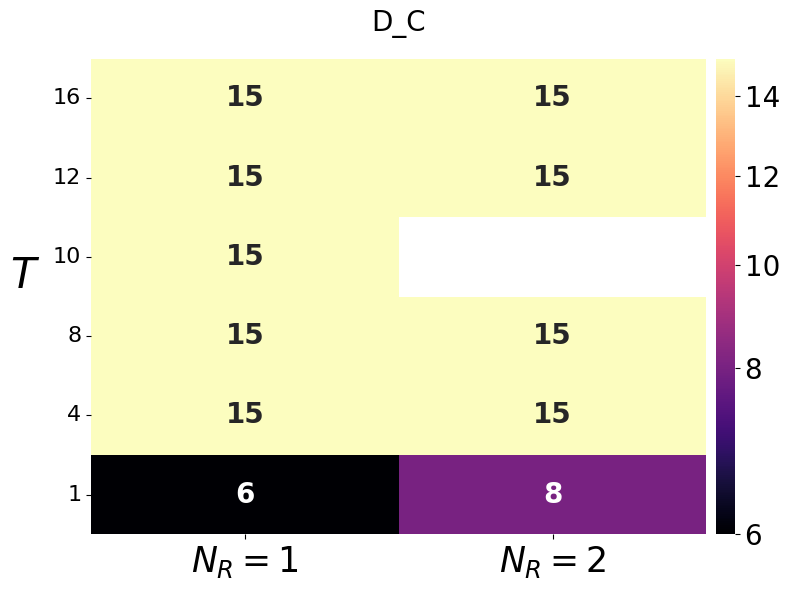

/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_82467/1727352913.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


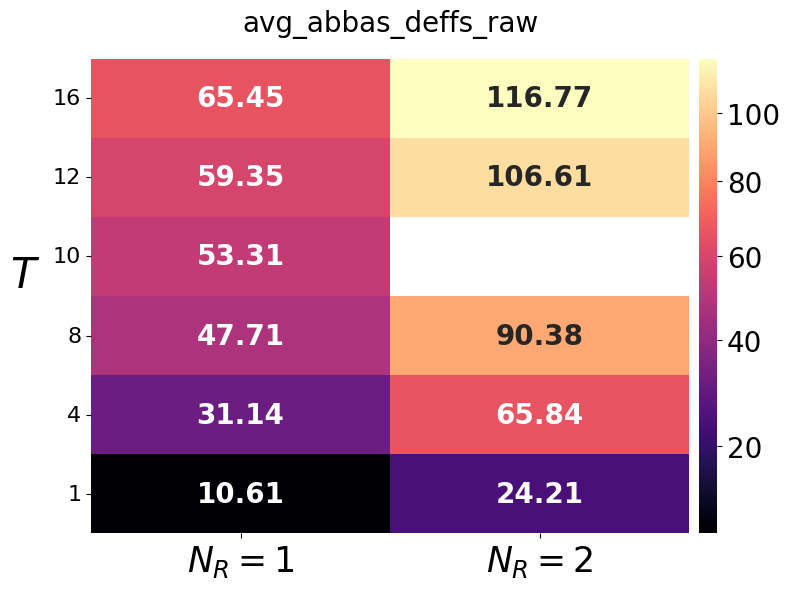

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
chosen_n_ctrl = 2
N_ctrl = chosen_n_ctrl
def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key, e.g.:
        metrics_info = {
            'mean_trace_eigvals': {
                'title': 'Mean Trace of QFIM',
                'cbar': ''
            },
            ...
        }
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3]

    # 2) Decide how to pick Trotter steps based on N_ctrl
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
    elif N_ctrl == 3:
        trots = np.arange(1, 60, 1)  # or your preferred range
    else:
        trots = [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 16, 18, 20]

    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary
        metric_title = metric_key
        metric_cbar=''
        # metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        # metric_cbar  = metrics_info.get(metric_key, {}).get('cbar', '')

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "D_C":
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(8, 6))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=0.7, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=16)
        ax.tick_params(axis='x', labelsize=16)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=25, rotation=0)

        plt.tight_layout()
        plt.show()

metric_keys = ['D_C', "spread_val_pooled_mad_normal",'avg_per_active_mode_avg_trace_norm_rank']
metric_keys = ['D_C','spectrum_shape_avg_abbas_deffs_norm','avg_abbas_deffs_raw','spectrum_shape_avg_ipr_deffs_norm']
# metric_keys = ['D_C','d_eff_ipr']

plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info={}, resies=[1,2,3])

In [3]:
def all_tuples_unique(tuples_list):
    # Return True if all items are unique (no duplicates)
    return len(tuples_list) == len(set(tuples_list))

df_all["all_key_pairs_unique"] = df_all["key_pair_tuple"].apply(all_tuples_unique)

df_Nr_1 = df_all[df_all['N_reserv'] == 1]

df_Nr_1[['N_ctrl','N_reserv','Trotter_Step','num_keys', 'key_pair_tuple','all_key_pairs_unique']].head()


,N_ctrl,N_reserv,Trotter_Step,num_keys,key_pair_tuple,all_key_pairs_unique
0,2,1,1,100,"[(fixed_params0, test0), (fixed_params0, test1...",True
1,2,1,10,100,"[(fixed_params0, test0), (fixed_params0, test1...",True
2,2,1,12,100,"[(fixed_params0, test0), (fixed_params0, test1...",True
3,2,1,14,100,"[(fixed_params0, test0), (fixed_params0, test1...",True
4,2,1,15,80,"[(fixed_params0, test0), (fixed_params0, test1...",True


In [5]:
from collections import Counter

for idx, row in df_all.iterrows():
    tuples_list = row["key_pair_tuple"]
    
    # --- Check overall tuple uniqueness ---
    tuple_counts = Counter(tuples_list)
    dup_tuples = [t for t, count in tuple_counts.items() if count > 1]
    if dup_tuples:
        print(f"\nRow {idx} (Nc={row['N_ctrl']},Nr={row['N_reserv']},T={row['Trotter_Step']}) has duplicate tuples in 'key_pair_tuple':")
        for dup in dup_tuples:
            print(f"  Tuple {dup} occurs {tuple_counts[dup]} times")
        print("Row details:")
        print(row)
    
    # # --- Check uniqueness of the second element ---
    # second_elems = [t[1] for t in tuples_list]
    # second_counts = Counter(second_elems)
    # dup_seconds = [sec for sec, count in second_counts.items() if count > 1]
    # if dup_seconds:
    #     print(f"\nRow {idx} (Nc={row['N_ctrl']},Nr={row['N_reserv']},T={row['Trotter_Step']})  has duplicate second elements in 'key_pair_tuple':")
    #     for sec in dup_seconds:
    #         # Get all tuples with this duplicate second element
    #         associated_tuples = [t for t in tuples_list if t[1] == sec]
    #         # The output shows each duplicate second element and its corresponding tuples,
    #         # making the first elements clear.
    #         print(f"  Second element {sec} appears in tuples: {associated_tuples}")
    #     print("Row details:")
    #     print(row)

In [36]:
for idx, row in df_Nr_1.iterrows():
    # Extract the list of tuples from the current row
    tuples_list = row["key_pair_tuple"]
    
    # Collect the second element of each tuple
    second_elems = [t[1] for t in tuples_list]
    
    # Assert that the second elements are unique
    assert len(second_elems) == len(set(second_elems)), f"Duplicate second element found in row {idx}: {len(second_elems)}, {len(set(second_elems))}"

AssertionError: Duplicate second element found in row 0: 500, 100

In [6]:
df_all.keys()
# /Users/so714f/Documents/offline/qrc/QFIM_results/analog/Nc_2
df_sub = df_all[(df_all['N_reserv']==1) & (df_all['Trotter_Step']==1) & (df_all['N_ctrl']==2)]
print(len(df_sub['all_qfim_eigvals']))
print(df_sub['all_qfim_eigvals'][0][0].shape)
print(df_sub.get('all_qfim_eigvals',[]))
df_sub.head()

1
(6,)
0    [[0.0002675529330928689, 0.06799820331152992, ...
Name: all_qfim_eigvals, dtype: object


,N_ctrl,N_reserv,Trotter_Step,all_qfim_eigvals,mean_entropy,num_test_keys,key_pair_tuple,num_keys,all_key_pairs_unique
0,2,1,1,"[[0.0002675529330928689, 0.06799820331152992, ...",0.406943,500,"[(fixed_params0, test0), (fixed_params0, test1...",100,True


In [22]:
df_with_stats[['N_ctrl','spectrum_shape_avg_ipr_deffs_norm', 'avg_ipr_deffs_raw']]
df_with_stats[['N_ctrl','spectrum_shape_avg_abbas_deffs_norm', 'spectrum_shape_avg_ipr_deffs_norm',]]

,N_ctrl,spectrum_shape_avg_abbas_deffs_norm,spectrum_shape_avg_ipr_deffs_norm
0,2,3.193173,1.314526
1,2,5.562233,3.616714
2,2,5.665785,3.711928
3,2,5.817823,4.024831
4,2,5.229582,4.138216
...,...,...,...
77,3,3.265608,8.935516
78,3,3.219342,8.503326
79,3,3.235018,8.675973
80,3,3.294703,9.705092


/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_38613/1346774657.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


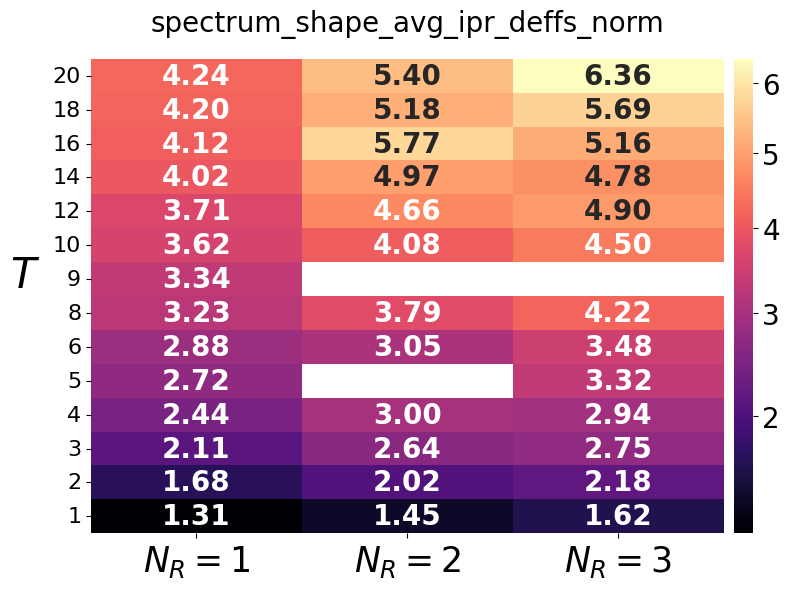

/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_38613/1346774657.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


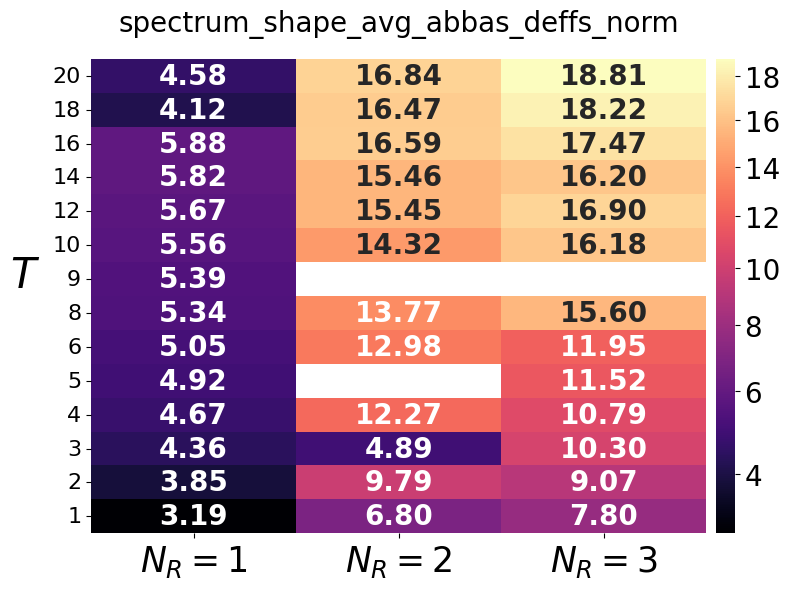

/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_38613/1346774657.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


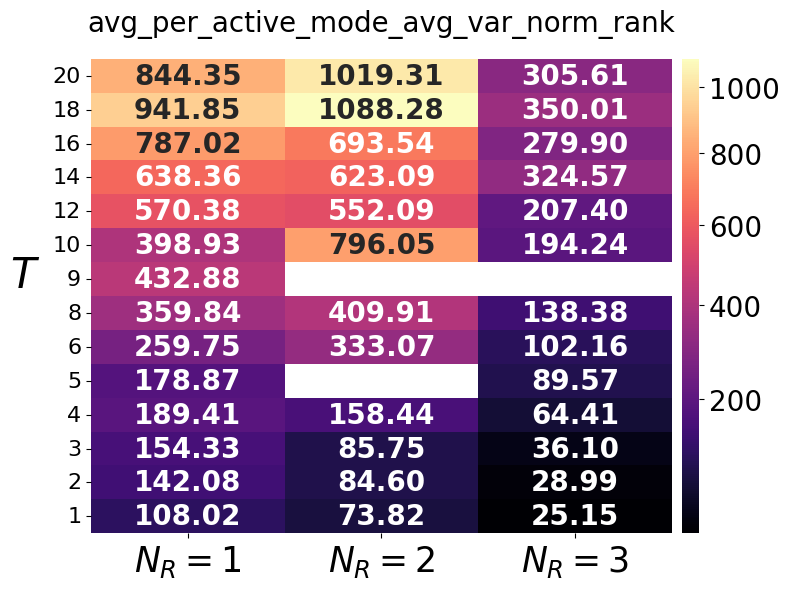

/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_38613/1346774657.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")


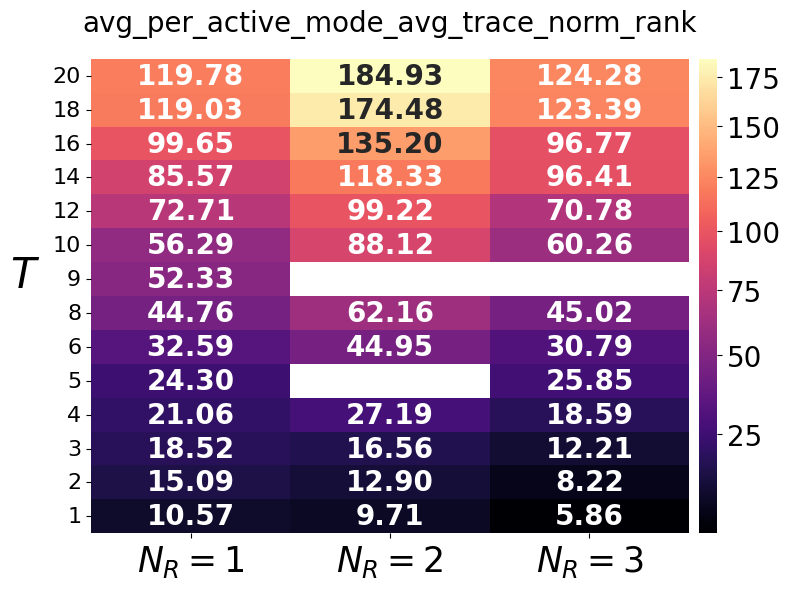

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
chosen_n_ctrl = 2
N_ctrl = chosen_n_ctrl
def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key, e.g.:
        metrics_info = {
            'mean_trace_eigvals': {
                'title': 'Mean Trace of QFIM',
                'cbar': ''
            },
            ...
        }
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3]

    # 2) Decide how to pick Trotter steps based on N_ctrl
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
    elif N_ctrl == 3:
        trots = np.arange(1, 60, 1)  # or your preferred range
    else:
        trots = [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 16, 18, 20]

    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary
        metric_title = metric_key
        metric_cbar=''
        # metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        # metric_cbar  = metrics_info.get(metric_key, {}).get('cbar', '')

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "D_C":
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(8, 6))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=0.7, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=16)
        ax.tick_params(axis='x', labelsize=16)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=25, rotation=0)

        plt.tight_layout()
        plt.show()

metric_keys = ['D_C', "spread_val_pooled_mad_normal",'avg_per_active_mode_avg_trace_norm_rank']
metric_keys = ['spectrum_shape_avg_ipr_deffs_norm','spectrum_shape_avg_abbas_deffs_norm','avg_per_active_mode_avg_var_norm_rank','avg_per_active_mode_avg_trace_norm_rank']
# metric_keys = ['D_C','d_eff_ipr']

plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info={}, resies=[1,2,3])